# 1 - Significance Heatmap

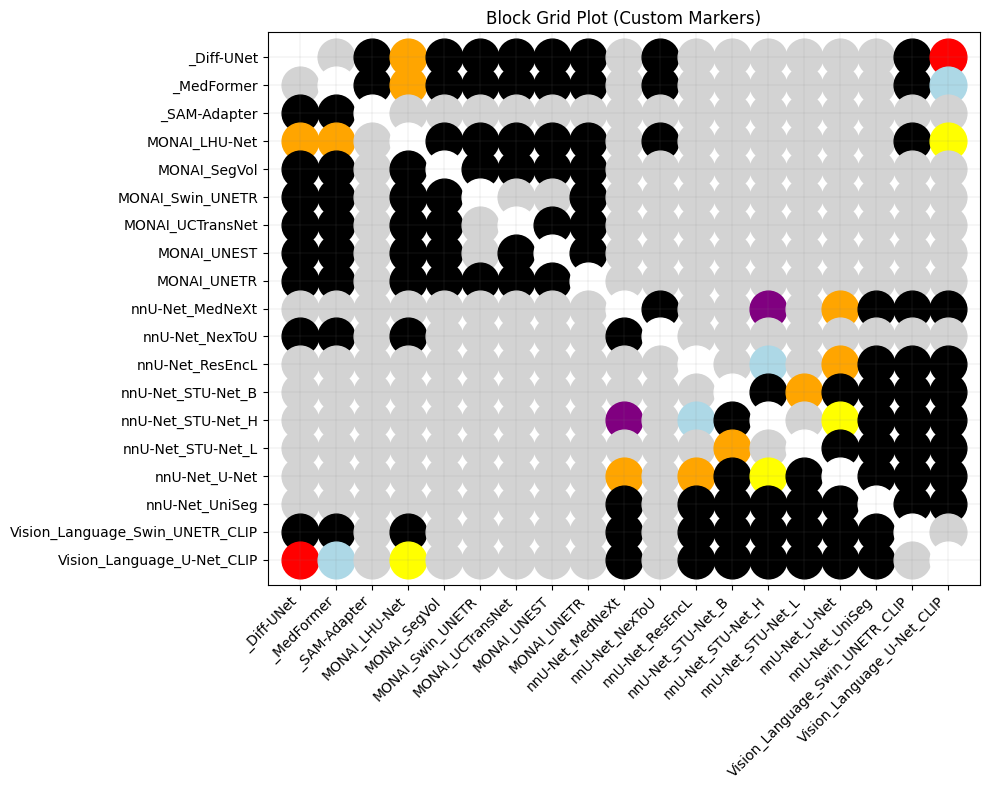

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def confidence_heatmap_version5(csv_path='df_heat.csv'):
    df = pd.read_csv(csv_path)
    df.replace("NA", np.nan, inplace=True)

    # We’ll just keep a list of all unique rows and columns
    rows = df['algoRow'].unique()
    cols = df['algoCol'].unique()
    row_index = {val: i for i, val in enumerate(rows)}
    col_index = {val: i for i, val in enumerate(cols)}

    # Plot setup
    plt.figure(figsize=(10,8))

    # We'll scatter plot each cell, controlling color or marker by tier
    tier_color_map = {
        '<75%': 'lightgray',
        '≥75%': 'lightblue',
        '≥90%': 'yellow',
        '≥95%': 'orange',
        '≥99%': 'red',
        '≥99.9%': 'darkred',
        '≥99.99%': 'purple',
        '≥99.999%': 'black'
    }

    for idx, row in df.iterrows():
        r = row['algoRow']
        c = row['algoCol']
        tier = row['confidenceTier']
        # We'll just do a square patch or a circle marker
        color = tier_color_map.get(tier, 'white')  # default to white if not found
        x = col_index[c]
        y = row_index[r]
        plt.scatter(x, y, color=color, edgecolor=None, s=700)  # s=800 => large marker size

        # # Optionally annotate the p-value or the tier
        # p = row['pval']
        # if pd.notna(p):
        #     if p == 0:
        #         text = "0"
        #     else:
        #         text = f"{p:.1e}"
        #     plt.text(x, y, text, va='center', ha='center', color='white', fontsize=7)

    # Invert y-axis if you want top row to appear at top
    plt.gca().invert_yaxis()

    # Ticks and labels
    plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
    plt.yticks(range(len(rows)), rows)
    plt.grid(True, color='gray', linewidth=0.1)

    plt.title("Block Grid Plot (Custom Markers)")
    plt.tight_layout()
    plt.show()

confidence_heatmap_version5()


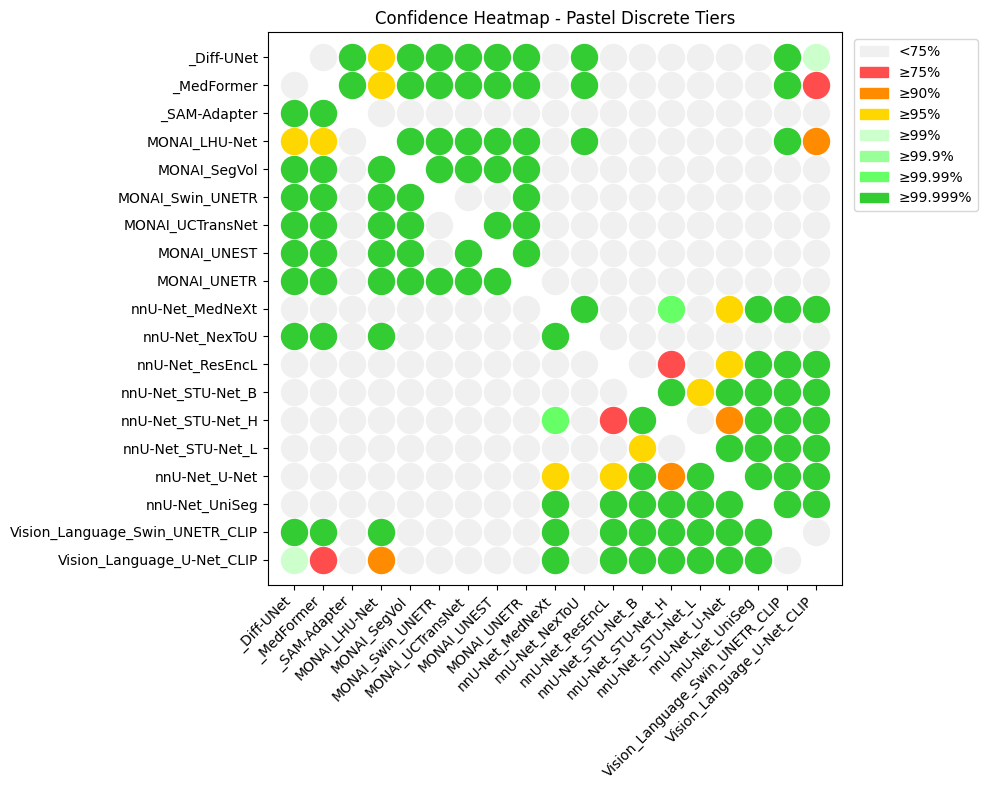

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def confidence_heatmap_pastel(csv_path='df_heat.csv'):
    df = pd.read_csv(csv_path)
    df.replace("NA", np.nan, inplace=True)

    # Unique rows/cols
    rows = df['algoRow'].unique()
    cols = df['algoCol'].unique()
    row_index = {val: i for i, val in enumerate(rows)}
    col_index = {val: i for i, val in enumerate(cols)}

    plt.figure(figsize=(10,8))

    # Tweak the color map to have pastel or "gentler" colors
    # Generally, you'd want the "least significant" to be a very light color
    # and the "most significant" to be a bolder color.
    # This is arbitrary; pick combos you like that are easy to read in grayscale if needed.
    # tier_color_map = {
    #     '<75%': '#dcdcdc',     # Gainsboro-like
    #     '≥75%': '#c5e1ec',     # Light pastel blue
    #     '≥90%': '#b3e6b3',     # Light pastel green
    #     '≥95%': '#ffe8b5',     # Pastel yellow
    #     '≥99%': '#ffc2b4',     # Pastel orange
    #     '≥99.9%': '#ffb3ff',   # Pastel magenta
    #     '≥99.99%': '#e5b3d1',  # Soft pink
    #     '≥99.999%': '#cab2d6'  # Light purple
    # }
    # tier_color_map = {
    #     '<75%': '#f0f0f0',     # Neutral light grey
    #     '≥75%': '#ffcccc',     # Pastel red
    #     '≥90%': '#ffe5cc',     # Pastel orange
    #     '≥95%': '#ffffcc',     # Pastel yellow
    #     '≥99%': '#ccffcc',     # Light green
    #     '≥99.9%': '#99ff99',   # Moderate green
    #     '≥99.99%': '#66ff66',  # More saturated green
    #     '≥99.999%': '#33cc33'  # Dark green
    # }

    tier_color_map = {
        '<75%': '#f0f0f0',     # Neutral light grey
        # '≥75%': '#ffb3b3',     # Light pastel red (less intense)
        '≥75%': '#ff4d4d',
        # '≥80%': '#ff9999',     # Soft pastel red
        # '≥85%': '#ff8080',     # Pastel red
        '≥90%': '#ff8c00',     # Soft pastel orange
        '≥95%': '#ffd700',     # Pastel yellow
        '≥99%': '#ccffcc',     # Light pastel green
        '≥99.9%': '#99ff99',   # Moderate pastel green
        '≥99.99%': '#66ff66',  # More saturated green
        '≥99.999%': '#33cc33'  # Dark green
    }

    # tier_color_map = {
    #     '<75%': '#f0f0f0',     # Neutral light grey
    #     '≥75%': '#ffb3d9',     # Light pastel pink
    #     # '≥80%': '#ffb3cc',     # Soft pastel pink
    #     # '≥85%': '#ff99cc',     # Pastel pink
    #     '≥90%': '#ffcccc',     # Pastel red
    #     '≥95%': '#ffb380',     # Pastel peach
    #     '≥99%': '#ffe5b3',     # Soft pastel orange
    #     '≥99.9%': '#ffffb3',   # Light pastel yellow
    #     '≥99.99%': '#b3ffb3',  # Soft pastel green
    #     '≥99.999%': '#99ffb3'  # More vibrant pastel green
    # }

    # tier_color_map = {
    #     '<75%': '#f0f0f0',     # Neutral light grey
    #     '≥75%': '#ffcccc',     # Light pastel red
    #     '≥75%': '#ffa3a3',     # Light pastel red
    #     '≥80%': '#ffb3b3',     # Soft pastel red
    #     # '≥85%': '#ffa3a3',     # Mild pastel red
    #     '≥90%': '#ffd699',     # Pastel orange
    #     '≥95%': '#ffff99',     # Pastel yellow
    #     '≥99%': '#d9ffb3',     # Light pastel green
    #     '≥99.9%': '#b3ff99',   # Moderate pastel green
    #     '≥99.99%': '#8cff8c',  # More saturated pastel green
    #     '≥99.999%': '#66ff66'  # Vivid pastel green
    # }



    # Plot each cell
    for idx, row in df.iterrows():
        r = row['algoRow']
        c = row['algoCol']
        tier = row['confidenceTier']
        color = tier_color_map.get(tier, 'white')  # default to white if not found
        x = col_index[c]
        y = row_index[r]
        # Scatter plot using large squares
        plt.scatter(x, y, color=color, edgecolor=None, s=350)#, marker='s')

    # Invert y-axis if you want the first row at the top
    plt.gca().invert_yaxis()

    # Ticks
    plt.xticks(range(len(cols)), cols, rotation=45, ha='right')
    plt.yticks(range(len(rows)), rows)
    # plt.grid(True, color='gray', linewidth=0.1)

    plt.title("Confidence Heatmap - Pastel Discrete Tiers")

    # Construct a legend from the discrete mapping
    # We create a patch for each tier so we can show a legend
    patches = []
    for tier_label, color_val in tier_color_map.items():
        patch = mpatches.Patch(color=color_val, label=tier_label)
        patches.append(patch)
    plt.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


confidence_heatmap_pastel()

In [111]:
import pandas as pd

def print_model_names(csv_path='df_heat.csv'):
    df = pd.read_csv(csv_path)

    # Get unique model names from algoRow and algoCol
    row_models = df['algoRow'].unique()
    col_models = df['algoCol'].unique()

    # Merge both lists and remove duplicates
    all_models = sorted(set(row_models) | set(col_models))

    # Print the model names
    print("Unique model names:")
    for model in all_models:
        print(model)

print_model_names()


Unique model names:
MONAI_LHU-Net
MONAI_SegVol
MONAI_Swin_UNETR
MONAI_UCTransNet
MONAI_UNEST
MONAI_UNETR
Vision_Language_Swin_UNETR_CLIP
Vision_Language_U-Net_CLIP
_Diff-UNet
_MedFormer
_SAM-Adapter
nnU-Net_MedNeXt
nnU-Net_NexToU
nnU-Net_ResEncL
nnU-Net_STU-Net_B
nnU-Net_STU-Net_H
nnU-Net_STU-Net_L
nnU-Net_U-Net
nnU-Net_UniSeg


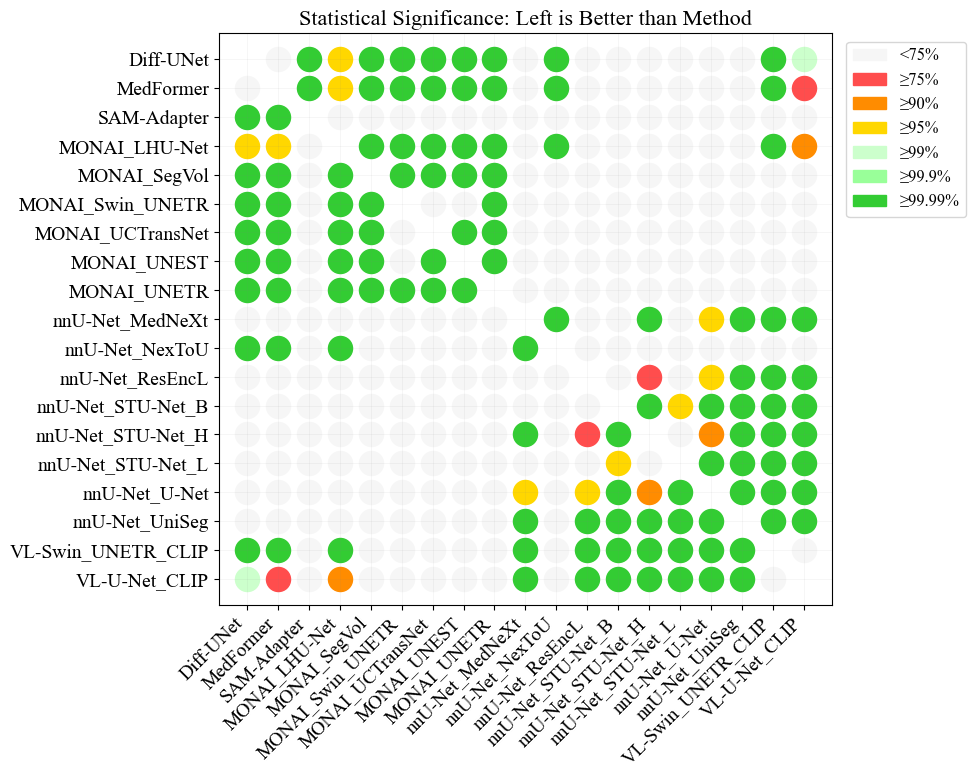

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def confidence_heatmap_pastel(csv_path='df_heat.csv'):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Times New Roman"]
    plt.rcParams["font.size"] = 14  # Increased font size by 2pt

    df = pd.read_csv(csv_path)

    # Define model name mapping
    model_name_mapping = {
        "_Diff-UNet": "Diff-UNet",
        "_MedFormer": "MedFormer",
        "_SAM-Adapter": "SAM-Adapter",
        "Vision_Language_Swin_UNETR_CLIP": "VL-Swin_UNETR_CLIP",
        "Vision_Language_U-Net_CLIP": "VL-U-Net_CLIP"
    }

    # Apply mapping to clean up model names
    df["algoRow"] = df["algoRow"].replace(model_name_mapping)
    df["algoCol"] = df["algoCol"].replace(model_name_mapping)

    # Unique rows/cols
    rows = df['algoRow'].unique()
    cols = df['algoCol'].unique()
    row_index = {val: i for i, val in enumerate(rows)}
    col_index = {val: i for i, val in enumerate(cols)}

    plt.figure(figsize=(10, 8))

    # Define the pastel color mapping with merged highest category.
    tier_color_map = {
        '<75%': '#f6f6f6',     # Neutral light grey
        '≥75%': '#ff4d4d',     # Light pastel red
        '≥90%': '#ff8c00',     # Soft pastel orange
        '≥95%': '#ffd700',     # Pastel yellow
        '≥99%': '#ccffcc',     # Light pastel green
        '≥99.9%': '#99ff99',   # Moderate pastel green
        '≥99.99%': '#33cc33'   # More saturated green (merged 99.99% and 99.999%)
    }

    # Plot each cell
    for idx, row in df.iterrows():
        r = row['algoRow']
        c = row['algoCol']
        tier = row['confidenceTier']
        # Merge 99.999% into 99.99%
        if tier == '≥99.999%':
            tier = '≥99.99%'
        color = tier_color_map.get(tier, 'white')  # default to white if not found
        x = col_index[c]
        y = row_index[r]
        plt.scatter(x, y, color=color, edgecolor=None, s=300)  # Reduced marker size for denser packing

    # Invert y-axis so the first row is at the top
    plt.gca().invert_yaxis()

    # Set ticks
    plt.xticks(range(len(cols)), cols, rotation=45, ha='right', fontsize=14)  # Increased font size
    plt.yticks(range(len(rows)), rows, fontsize=14)  # Increased font size

    plt.title("Statistical Significance: Left is Better than Method", fontsize=16)  # Increased title font size

    # Construct a legend from the discrete mapping
    patches = [mpatches.Patch(color=color_val, label=tier_label)
               for tier_label, color_val in tier_color_map.items()]
    plt.legend(handles=patches, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=12)  # Increased legend font size

    plt.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.1)  # Light gray gridlines

    plt.tight_layout()

    plt.savefig("figures/fig2_stat_sign.pdf", format='pdf', dpi=300)#, bbox_inches='tight', pad_inches=1)


    plt.show()

confidence_heatmap_pastel()


### Interpolation sucks

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def confidence_heatmap_interpolation_comparison(csv_path='df_heat.csv'):
    # Read CSV and replace "NA" strings with np.nan
    df = pd.read_csv(csv_path)
    # df.replace("nan", 0, inplace=True)

    # Define the ordered discrete tiers
    tier_levels = ['<75%', '≥75%', '≥90%', '≥95%', '≥99%', '≥99.9%', '≥99.99%', '≥99.999%']
    # Map each tier to an integer value (1, 2, …, 8)
    tier_to_numeric = {tier: i+1 for i, tier in enumerate(tier_levels)}

    # Pivot the data: rows=algoRow, columns=algoCol, values=confidenceTier (as text)
    heatmap_data = df.pivot(index='algoRow', columns='algoCol', values='confidenceTier')
    # Convert tiers to numeric values using our mapping
    heatmap_data_numeric = heatmap_data.applymap(lambda x: tier_to_numeric.get(x, np.nan))

    # Fill NaNs with the column mean to smooth out the transitions
    heatmap_filled = heatmap_data_numeric.copy().astype(float)
    heatmap_filled = heatmap_filled.apply(lambda col: col.fillna(col.mean()), axis=0)

    # Define a custom palette:
    custom_colors = [
        '#f0f0f0',  # <75% : neutral light grey
        '#ffcccc',  # ≥75% : pastel red
        '#ffe5cc',  # ≥90% : pastel orange
        '#ffffcc',  # ≥95% : pastel yellow
        '#ccffcc',  # ≥99% : light green
        '#99ff99',  # ≥99.9%: moderate green
        '#66ff66',  # ≥99.99%: more saturated green
        '#33cc33'   # ≥99.999%: dark green
    ]
    custom_cmap = ListedColormap(custom_colors)

    # List of available interpolation methods in imshow
    interpolation_methods = [
        'none', 'nearest', 'bilinear', 'bicubic', 'spline16', 'spline36', 'hanning',
        'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell',
        'sinc', 'lanczos'
    ]

    for interp in interpolation_methods:
        fig, ax = plt.subplots(figsize=(12, 10))
        im = ax.imshow(heatmap_filled, cmap=custom_cmap, aspect="auto",
                       interpolation=interp, vmin=1, vmax=len(tier_levels))

        # Set axis ticks and labels
        ax.set_xticks(np.arange(heatmap_filled.shape[1]))
        ax.set_yticks(np.arange(heatmap_filled.shape[0]))
        ax.set_xticklabels(heatmap_filled.columns, rotation=90, fontsize=10)
        ax.set_yticklabels(heatmap_filled.index, fontsize=10)
        ax.set_title(f"Confidence Heatmap with {interp} Interpolation", fontsize=14, fontweight="bold")

        # Add a colorbar with discrete ticks corresponding to the tiers
        cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.04)
        cbar.set_ticks(np.arange(1, len(tier_levels) + 1))
        cbar.set_ticklabels(tier_levels)
        cbar.set_label("Confidence Tier", fontsize=12)

        plt.tight_layout()
        plt.show()

# Call the function to generate the plots
confidence_heatmap_interpolation_comparison()


#  2- DSC vs. NSD, as appropriate, by organ

#### Most basic - needs csv

In [7]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
df_metric = pd.read_csv("organ_perf_dsc_merged.csv")

# Display the first few rows
print(df_metric.head())


    case  organ     value        algo
0  s0001  aorta  0.896496  _Diff-UNet
1  s0006  aorta  0.968756  _Diff-UNet
2  s0009  aorta  0.982722  _Diff-UNet
3  s0012  aorta  0.889999  _Diff-UNet
4  s0013  aorta  0.979722  _Diff-UNet


In [8]:
unique_organs = df_metric["organ"].unique()

for org in unique_organs:
    # Subset just this organ
    sub_df = df_metric[df_metric["organ"] == org]

    # Group by algo, compute mean of value
    agg_df = (
        sub_df
        .groupby("algo", as_index=False)["value"]
        .mean()
        .rename(columns={"value": "mean_value"})
    )

    # Sort descending if bigger metric => better
    agg_df = agg_df.sort_values("mean_value", ascending=False)

    # Assign a rank (1 = best)
    agg_df["rank"] = range(1, len(agg_df) + 1)

    print("=== Organ:", org, "===")
    print(agg_df.to_string(index=False))
    print()


=== Organ: aorta ===
                           algo  mean_value  rank
              nnU-Net_STU-Net_L    0.740417     1
              nnU-Net_STU-Net_H    0.726646     2
              nnU-Net_STU-Net_B    0.718101     3
                nnU-Net_ResEncL    0.713468     4
                nnU-Net_MedNeXt    0.695329     5
                  nnU-Net_U-Net    0.684460     6
                     _MedFormer    0.678518     7
                 nnU-Net_UniSeg    0.673310     8
                 nnU-Net_NexToU    0.595173     9
                  MONAI_LHU-Net    0.591955    10
                     _Diff-UNet    0.577087    11
                   MONAI_SegVol    0.576092    12
     Vision_Language_U-Net_CLIP    0.574811    13
Vision_Language_Swin_UNETR_CLIP    0.565573    14
                    MONAI_UNEST    0.515975    15
               MONAI_Swin_UNETR    0.511609    16
               MONAI_UCTransNet    0.481466    17
                    MONAI_UNETR    0.368090    18
                   _SAM-Adapt

### Reimplementation of R code in Py

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import rankdata
from scipy.spatial.distance import pdist, squareform

# Path to parent folder containing one subfolder per algorithm
parent_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# List subdirectories (one per algorithm)
model_dirs = [os.path.join(parent_dir, d) for d in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, d))]

# Our 9 organs of interest
all_organs = ["aorta", "gall_bladder", "kidney_left", "kidney_right",
              "liver", "pancreas", "postcava", "spleen", "stomach"]

# Decide which metric to use for each organ: DSC vs NSD
organs_use_nsd = {"aorta", "postcava"}
organs_use_dsc = set(all_organs) - organs_use_nsd

# Directory to save plots (optional)
out_plots_dir = "figures/2_dsc_nsd_by_organ/prettier"
os.makedirs(out_plots_dir, exist_ok=True)


def read_metric_data(metric, organs):
    """
    Read the CSV data from each algorithm folder and pivot to long format.

    Parameters:
        metric (str): "dsc" or "nsd"
        organs (list): List of organs to extract

    Returns:
        pd.DataFrame: Combined long-format data from all algorithm results
    """
    all_data = []

    for mdir in model_dirs:
        csv_file = os.path.join(mdir, f"{metric}.csv")
        if not os.path.exists(csv_file):
            print(f"Skipping: no {metric}.csv in {mdir}")
            continue

        df = pd.read_csv(csv_file)

        if 'name' not in df.columns:
            print(f"Skipping: {csv_file} missing 'name' column")
            continue

        df_long = df.melt(id_vars=['name'], value_vars=organs, var_name='organ', value_name='value')
        df_long.rename(columns={'name': 'case'}, inplace=True)
        df_long['algo'] = os.path.basename(mdir)

        # Remove rows with NaN values
        df_long = df_long.dropna()

        all_data.append(df_long)

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame(columns=['case', 'organ', 'value', 'algo'])


def compute_ranking(df):
    """
    Compute ranking of algorithms using statistical significance.

    Parameters:
        df (pd.DataFrame): Dataframe containing algorithm performance

    Returns:
        pd.DataFrame: Dataframe with ranking per algorithm
    """
    algo_means = df.groupby('algo')['value'].mean()
    rankings = rankdata(-algo_means, method='min')  # Higher value = better rank
    rank_df = pd.DataFrame({'algo': algo_means.index, 'mean_score': algo_means.values, 'rank': rankings})
    return rank_df.sort_values(by='rank')


def bootstrap_ranking(df, nboot=200):
    """
    Perform bootstrapping to compute rank distributions.

    Parameters:
        df (pd.DataFrame): Algorithm performance data
        nboot (int): Number of bootstrap samples

    Returns:
        pd.DataFrame: Bootstrapped rank distributions
    """
    boot_ranks = []
    algos = df['algo'].unique()

    for _ in range(nboot):
        sample = df.sample(frac=1, replace=True)
        rank_sample = compute_ranking(sample)
        boot_ranks.append(rank_sample[['algo', 'rank']])

    boot_df = pd.concat(boot_ranks)
    return boot_df


import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import rankdata

# Path to save improved plots
out_plots_dir = "figures/2_dsc_nsd_by_organ"
os.makedirs(out_plots_dir, exist_ok=True)

# Iterate over all organs and generate improved box plots
for org in all_organs:
    metric_choice = "nsd" if org in organs_use_nsd else "dsc"
    df_metric = read_metric_data(metric_choice, [org])

    if df_metric.empty:
        print(f"No data found for organ {org} with metric={metric_choice} -- skipping.")
        continue

    # Sort algorithms by median performance (best-performing first)
    algo_order = df_metric.groupby("algo")["value"].median().sort_values(ascending=False).index

    # Dynamically generate a large enough color palette
    num_algos = len(algo_order)
    palette = sns.color_palette("coolwarm", n_colors=num_algos)

    # Create figure
    plt.figure(figsize=(10, 6))

    # Box plot (assign hue="algo" to avoid the FutureWarning)
    sns.boxplot(
        data=df_metric,
        x="value",
        y="algo",
        order=algo_order,
        hue="algo",
        palette=palette,
        showfliers=False,
        linewidth=1.5,
        legend=False  # Hide redundant legend
    )

    # Strip plot (reduce dot size & adjust jitter for clarity)
    sns.stripplot(
        data=df_metric,
        x="value",
        y="algo",
        order=algo_order,
        color='black',
        size=3,  # Smaller dots
        jitter=0.15,  # Adjust jitter to prevent excessive clustering
        alpha=0.6  # Reduce opacity for clarity
    )

    # Improve readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Performance Score (Higher is Better)", fontsize=14)
    plt.ylabel("Algorithm", fontsize=14)
    plt.title(f"Algorithm Performance for {org} ({metric_choice.upper()})", fontsize=16, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.5)

    # Save the improved plot
    plt.savefig(os.path.join(out_plots_dir, f"box_{org}_{metric_choice}.png"), dpi=300, bbox_inches='tight')
    plt.close()

print("Updated, aesthetically improved box plots saved.")

Updated, aesthetically improved box plots saved.


## Model Rankings

### DSC & NSD across all organs

### Barchart IQR

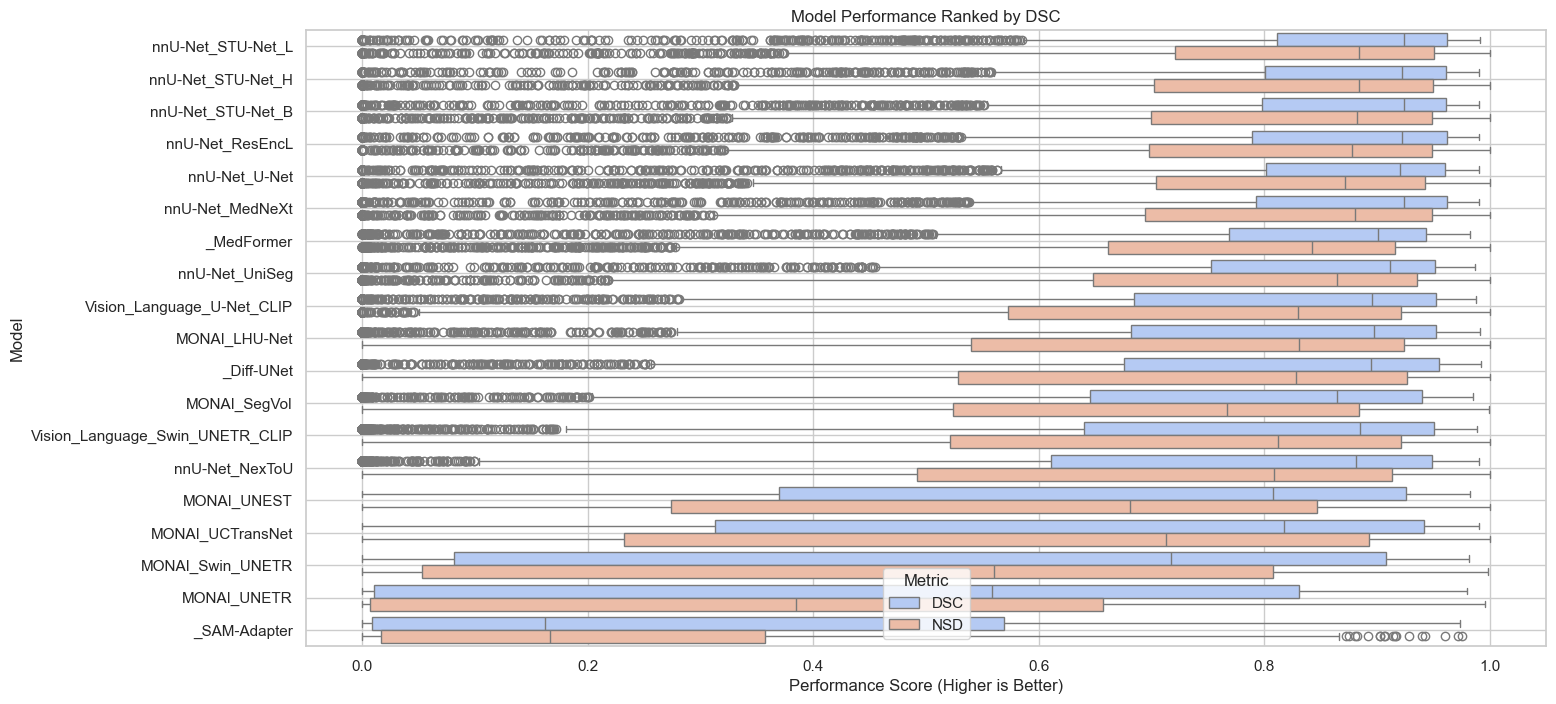

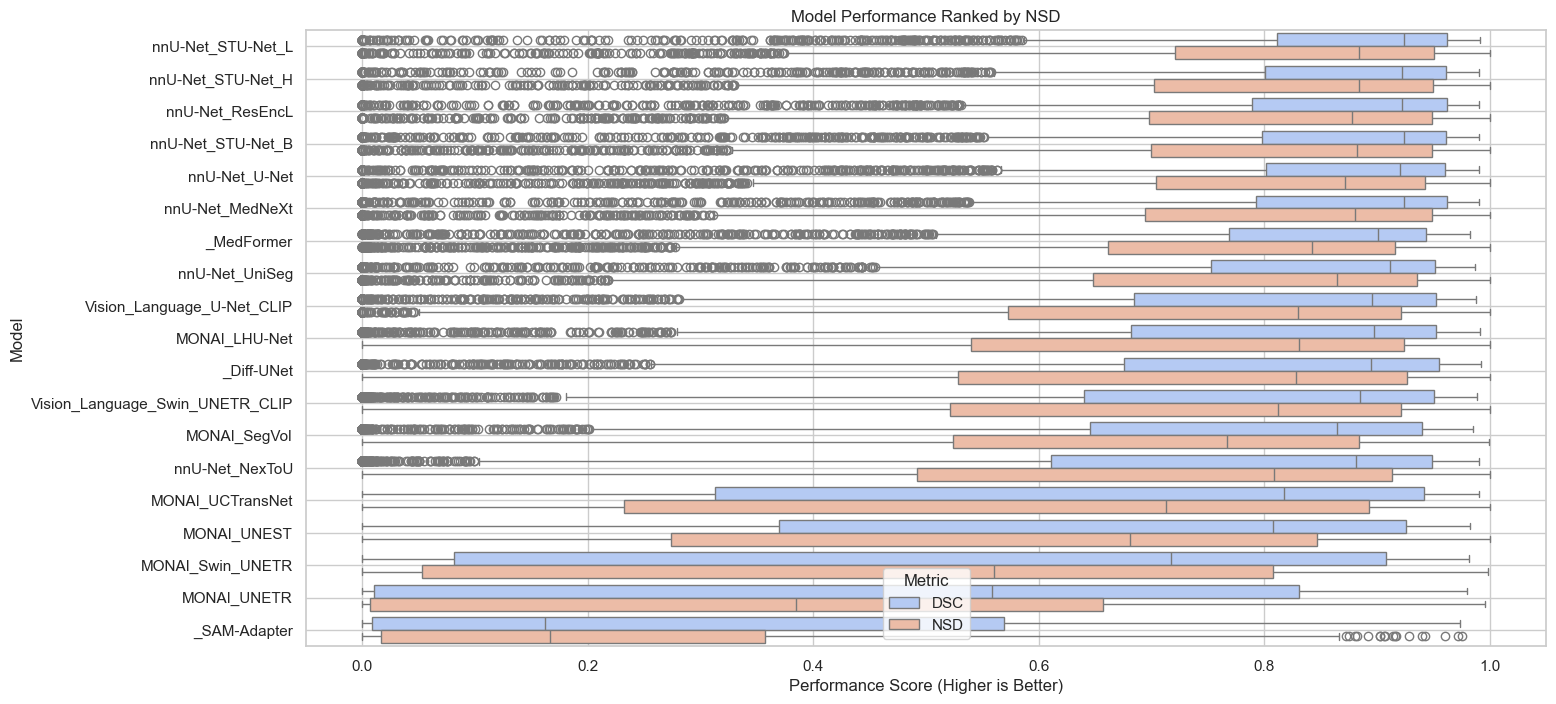

In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a list to store all data
all_model_data = []

# Define the extracted directory path
base_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# List all model directories (ignore metadata file)
model_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Read and aggregate data from each model's DSC and NSD files
for model in model_dirs:
    model_path = os.path.join(base_dir, model)

    # Read DSC file if it exists
    dsc_file = os.path.join(model_path, "dsc.csv")
    if os.path.exists(dsc_file):
        df_dsc = pd.read_csv(dsc_file)
        df_dsc = df_dsc.drop(columns=['name'], errors='ignore')  # Remove case names if present
        df_dsc = df_dsc.melt(var_name="organ", value_name="value")  # Aggregate across organs
        df_dsc["model"] = model
        df_dsc["metric"] = "DSC"
        df_dsc.dropna(inplace=True)  # Remove NaN values
        all_model_data.append(df_dsc)

    # Read NSD file if it exists
    nsd_file = os.path.join(model_path, "nsd.csv")
    if os.path.exists(nsd_file):
        df_nsd = pd.read_csv(nsd_file)
        df_nsd = df_nsd.drop(columns=['name'], errors='ignore')  # Remove case names if present
        df_nsd = df_nsd.melt(var_name="organ", value_name="value")  # Aggregate across organs
        df_nsd["model"] = model
        df_nsd["metric"] = "NSD"
        df_nsd.dropna(inplace=True)  # Remove NaN values
        all_model_data.append(df_nsd)

# Merge all collected data
df_all_models = pd.concat(all_model_data, ignore_index=True)

# Compute mean performance per model & metric
model_ranking = df_all_models.groupby(["model", "metric"])["value"].mean().reset_index()

# Sort models separately for DSC and NSD rankings
dsc_sorted_models = model_ranking[model_ranking["metric"] == "DSC"].sort_values(by="value", ascending=False)["model"]
nsd_sorted_models = model_ranking[model_ranking["metric"] == "NSD"].sort_values(by="value", ascending=False)["model"]

# Plot: Box plot ranked by DSC performance
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=df_all_models,
    x="value",
    y="model",
    hue="metric",
    showfliers=True,
    palette="coolwarm",
    order=dsc_sorted_models  # Ranked by DSC
)
plt.xlabel("Performance Score (Higher is Better)")
plt.ylabel("Model")
plt.title("Model Performance Ranked by DSC")
plt.legend(title="Metric")
plt.grid(True)
plt.show()

# Plot: Box plot ranked by NSD performance
plt.figure(figsize=(16, 8))
sns.boxplot(
    data=df_all_models,
    x="value",
    y="model",
    hue="metric",
    showfliers=True,
    palette="coolwarm",
    order=nsd_sorted_models  # Ranked by NSD
)
plt.xlabel("Performance Score (Higher is Better)")
plt.ylabel("Model")
plt.title("Model Performance Ranked by NSD")
plt.legend(title="Metric")
plt.grid(True)
plt.show()

### Dumbbell and Parallel Plots

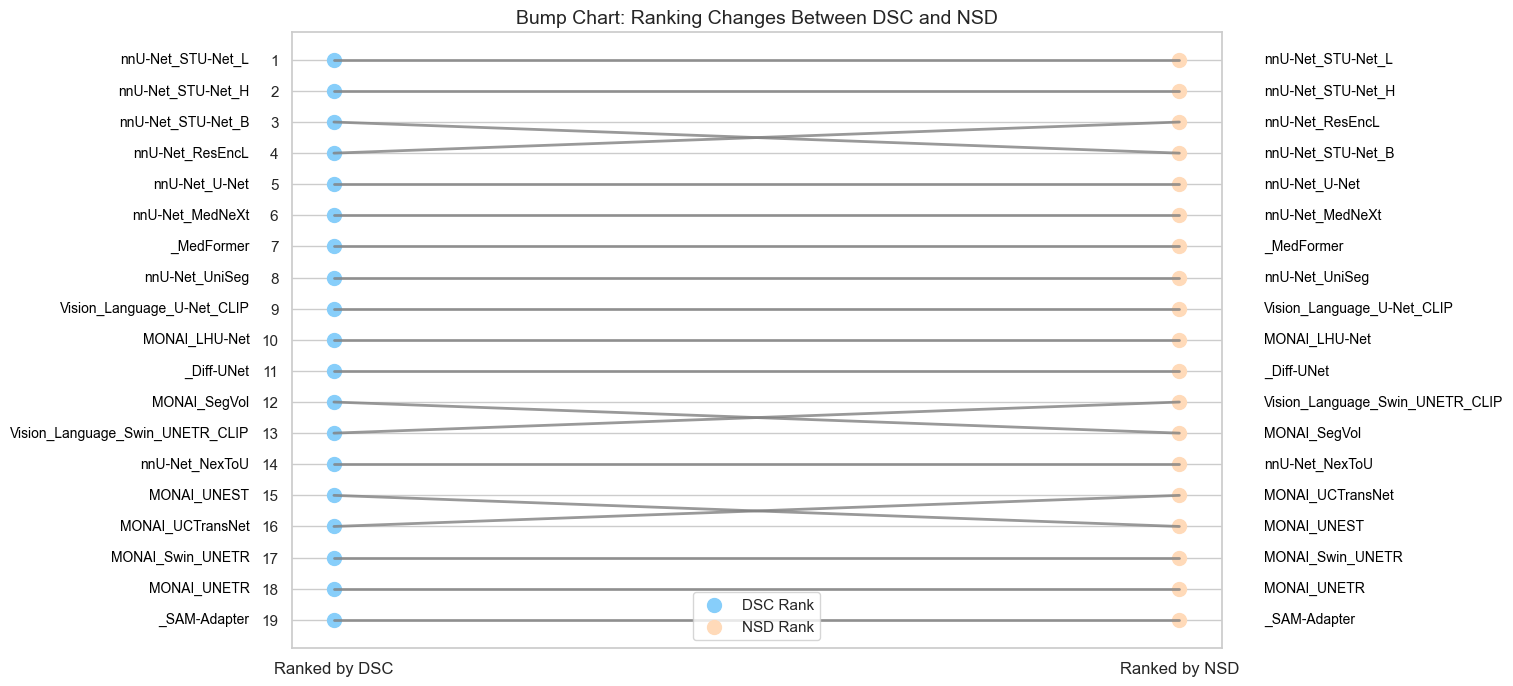

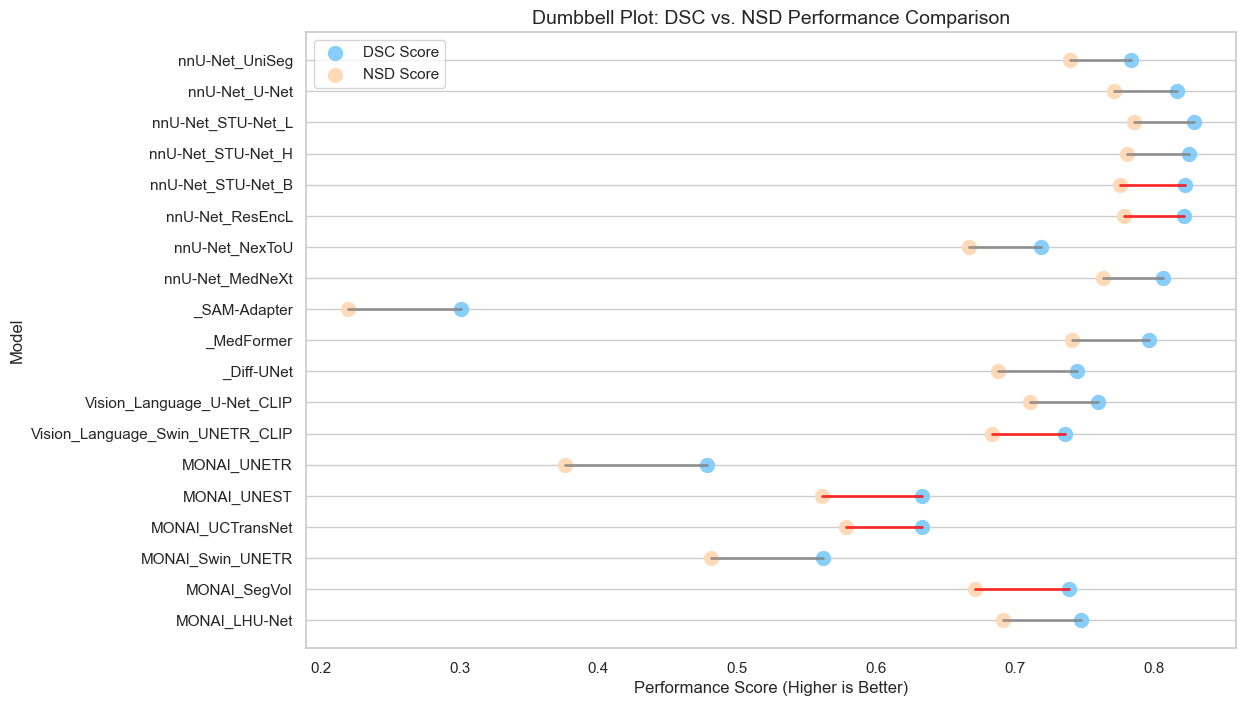

In [18]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# --- 2. Load Performance Data ---
all_model_data = []
base_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

model_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for model in model_dirs:
    model_path = os.path.join(base_dir, model)

    # Read DSC file if available
    dsc_file = os.path.join(model_path, "dsc.csv")
    if os.path.exists(dsc_file):
        df_dsc = pd.read_csv(dsc_file)
        df_dsc = df_dsc.drop(columns=['name'], errors='ignore')
        df_dsc = df_dsc.melt(var_name="organ", value_name="value")
        df_dsc["model"] = model
        df_dsc["metric"] = "DSC"
        df_dsc.dropna(inplace=True)
        all_model_data.append(df_dsc)

    # Read NSD file if available
    nsd_file = os.path.join(model_path, "nsd.csv")
    if os.path.exists(nsd_file):
        df_nsd = pd.read_csv(nsd_file)
        df_nsd = df_nsd.drop(columns=['name'], errors='ignore')
        df_nsd = df_nsd.melt(var_name="organ", value_name="value")
        df_nsd["model"] = model
        df_nsd["metric"] = "NSD"
        df_nsd.dropna(inplace=True)
        all_model_data.append(df_nsd)

df_all_models = pd.concat(all_model_data, ignore_index=True)

# --- 3. Compute Model Rankings ---
model_ranking = df_all_models.groupby(["model", "metric"])["value"].mean().reset_index()

dsc_ranking = model_ranking[model_ranking["metric"] == "DSC"].set_index("model")["value"].rank(ascending=False)
nsd_ranking = model_ranking[model_ranking["metric"] == "NSD"].set_index("model")["value"].rank(ascending=False)

rank_changes = (dsc_ranking - nsd_ranking).abs()
models_with_changes = rank_changes[rank_changes > 0].index.tolist()

# --- Define Colors to Match the Box Plots ---
PASTEL_BLUE   = "#87CEFA"  # DSC color
PASTEL_ORANGE = "#FFDAB9"  # NSD color
GRAY          = "gray"
RED           = "red"

# ----------------------------------------------------------------------
# 4. Bump Chart: Ranking Changes
# ----------------------------------------------------------------------
bump_chart_df = pd.DataFrame({
    "Model": dsc_ranking.index,
    "DSC Rank": dsc_ranking.values,
    "NSD Rank": nsd_ranking.loc[dsc_ranking.index].values
})

bump_chart_df["Rank Change"] = np.abs(bump_chart_df["DSC Rank"] - bump_chart_df["NSD Rank"])
# Decide when to highlight in red (here: >1 rank difference)
bump_chart_df["Highlight"] = bump_chart_df["Rank Change"] > 1

plt.figure(figsize=(12, 8))

# Draw connection lines between DSC Rank and NSD Rank
for _, row in bump_chart_df.iterrows():
    color_line = RED if row["Highlight"] else GRAY
    plt.plot([1, 2], [row["DSC Rank"], row["NSD Rank"]], color=color_line, linewidth=2, alpha=0.8)

# Scatter points for DSC
plt.scatter(
    np.ones(len(dsc_ranking)),
    dsc_ranking,
    color=PASTEL_BLUE,
    s=100,
    label="DSC Rank"
)

# Scatter points for NSD
plt.scatter(
    np.ones(len(nsd_ranking)) * 2,
    nsd_ranking,
    color=PASTEL_ORANGE,
    s=100,
    label="NSD Rank"
)

# Annotate model names
for _, row in bump_chart_df.iterrows():
    plt.text(0.9, row["DSC Rank"], row["Model"], ha="right", va="center", fontsize=10, color="black")
    plt.text(2.1, row["NSD Rank"], row["Model"], ha="left", va="center", fontsize=10, color="black")

plt.xticks([1, 2], ["Ranked by DSC", "Ranked by NSD"], fontsize=12)
plt.yticks(range(1, len(dsc_ranking) + 1))
plt.gca().invert_yaxis()  # Put Rank=1 at the top
plt.title("Bump Chart: Ranking Changes Between DSC and NSD", fontsize=14)
plt.legend()
plt.grid(axis="x")
plt.show()

# ----------------------------------------------------------------------
# 5. Dumbbell Plot: Performance Comparison
# ----------------------------------------------------------------------
dumbbell_df = model_ranking.pivot(index="model", columns="metric", values="value").reset_index()
dumbbell_df["Highlight"] = dumbbell_df["model"].isin(models_with_changes)

plt.figure(figsize=(12, 8))

# Draw dumbbell lines
for _, row in dumbbell_df.iterrows():
    color_line = RED if row["Highlight"] else GRAY
    plt.plot(
        [row["DSC"], row["NSD"]],
        [row["model"], row["model"]],
        color=color_line,
        linewidth=2,
        alpha=0.8
    )

# Scatter points for DSC
plt.scatter(
    dumbbell_df["DSC"],
    dumbbell_df["model"],
    color=PASTEL_BLUE,
    s=100,
    label="DSC Score"
)

# Scatter points for NSD
plt.scatter(
    dumbbell_df["NSD"],
    dumbbell_df["model"],
    color=PASTEL_ORANGE,
    s=100,
    label="NSD Score"
)

plt.xlabel("Performance Score (Higher is Better)", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.title("Dumbbell Plot: DSC vs. NSD Performance Comparison", fontsize=14)
plt.legend()
plt.grid(axis="x")
plt.show()

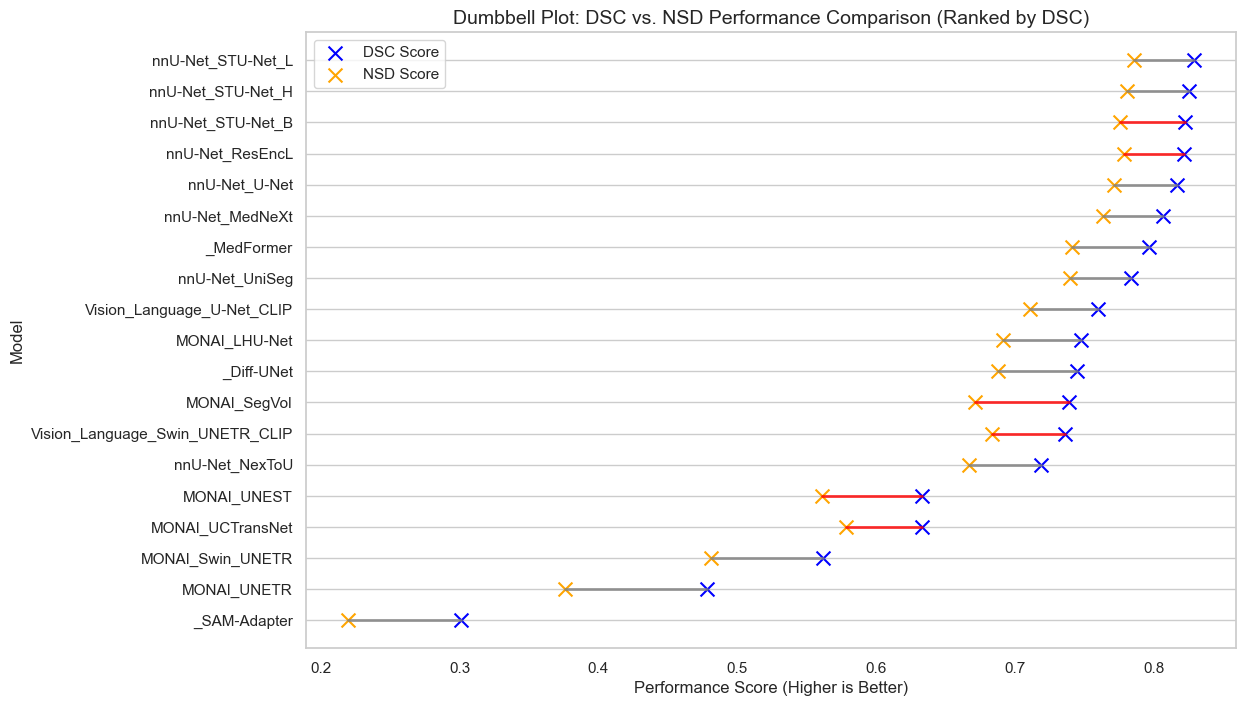

In [21]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# --- 2. Load Performance Data ---
all_model_data = []
base_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

model_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for model in model_dirs:
    model_path = os.path.join(base_dir, model)

    # Read DSC file if available
    dsc_file = os.path.join(model_path, "dsc.csv")
    if os.path.exists(dsc_file):
        df_dsc = pd.read_csv(dsc_file)
        df_dsc = df_dsc.drop(columns=['name'], errors='ignore')
        df_dsc = df_dsc.melt(var_name="organ", value_name="value")
        df_dsc["model"] = model
        df_dsc["metric"] = "DSC"
        df_dsc.dropna(inplace=True)
        all_model_data.append(df_dsc)

    # Read NSD file if available
    nsd_file = os.path.join(model_path, "nsd.csv")
    if os.path.exists(nsd_file):
        df_nsd = pd.read_csv(nsd_file)
        df_nsd = df_nsd.drop(columns=['name'], errors='ignore')
        df_nsd = df_nsd.melt(var_name="organ", value_name="value")
        df_nsd["model"] = model
        df_nsd["metric"] = "NSD"
        df_nsd.dropna(inplace=True)
        all_model_data.append(df_nsd)

df_all_models = pd.concat(all_model_data, ignore_index=True)

# --- 3. Compute Model Rankings ---
model_ranking = df_all_models.groupby(["model", "metric"])["value"].mean().reset_index()

# Rank models based on DSC and NSD performance
dsc_ranking = model_ranking[model_ranking["metric"] == "DSC"].set_index("model")["value"].rank(ascending=True)
nsd_ranking = model_ranking[model_ranking["metric"] == "NSD"].set_index("model")["value"].rank(ascending=True)

rank_changes = (dsc_ranking - nsd_ranking).abs()
models_with_changes = rank_changes[rank_changes > 0].index.tolist()

# ----------------------------------------------------------------------
# 4. Dumbbell Plot: Performance Comparison (Ranked by DSC)
# ----------------------------------------------------------------------

# Pivot the model rankings for dumbbell plot
dumbbell_df = model_ranking.pivot(index="model", columns="metric", values="value").reset_index()
dumbbell_df["Highlight"] = dumbbell_df["model"].isin(models_with_changes)

# Sort models by DSC ranking (best DSC model at the top)
sorted_models_by_dsc = dsc_ranking.sort_values().index
dumbbell_df_sorted = dumbbell_df.set_index("model").loc[sorted_models_by_dsc].reset_index()

# Define colors for dumbbell plot
BLUE = "blue"
ORANGE = "orange"
GRAY = "gray"
RED = "red"

plt.figure(figsize=(12, 8))

# Draw dumbbell lines
for _, row in dumbbell_df_sorted.iterrows():
    color = RED if row["Highlight"] else GRAY
    plt.plot([row["DSC"], row["NSD"]], [row["model"], row["model"]], color=color, linewidth=2, alpha=0.8)

# Scatter points for DSC (Blue X markers)
plt.scatter(dumbbell_df_sorted["DSC"], dumbbell_df_sorted["model"], color=BLUE, marker="x", s=100, label="DSC Score")

# Scatter points for NSD (Orange X markers)
plt.scatter(dumbbell_df_sorted["NSD"], dumbbell_df_sorted["model"], color=ORANGE, marker="x", s=100, label="NSD Score")

# Aesthetic settings
plt.xlabel("Performance Score (Higher is Better)", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.title("Dumbbell Plot: DSC vs. NSD Performance Comparison (Ranked by DSC)", fontsize=14)
plt.legend()
plt.grid(axis="x")

# Show the dumbbell plot
plt.show()

#### Same but `o3-mini-high`

- Confirms weird looking plot. Need to check data, to match TS

https://chatgpt.com/share/67b89bc8-54d4-8006-a9cf-a6f9a4c80432

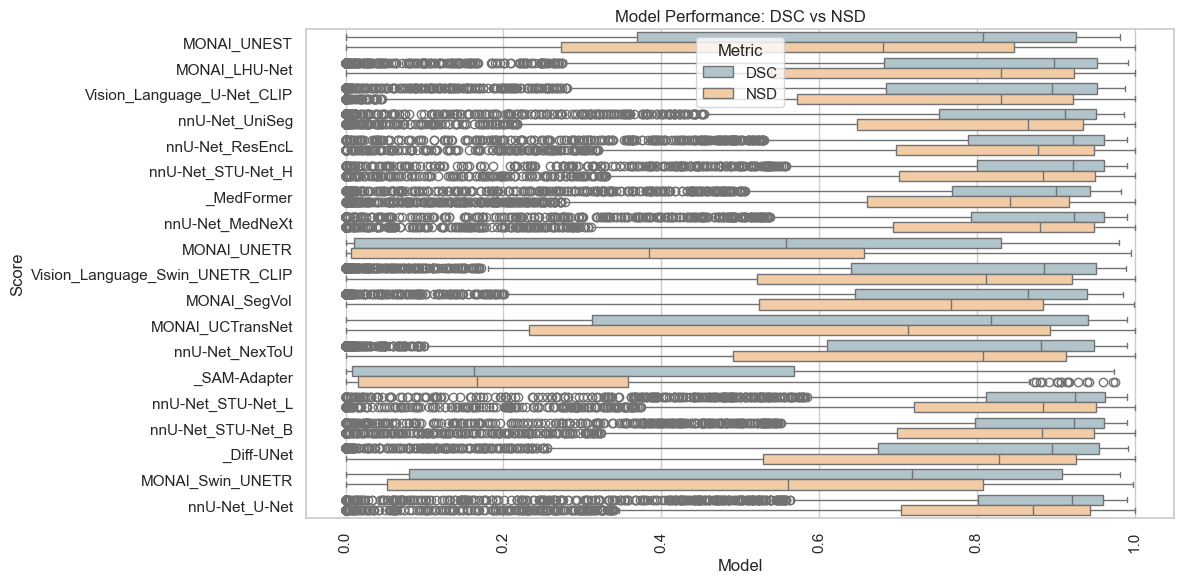

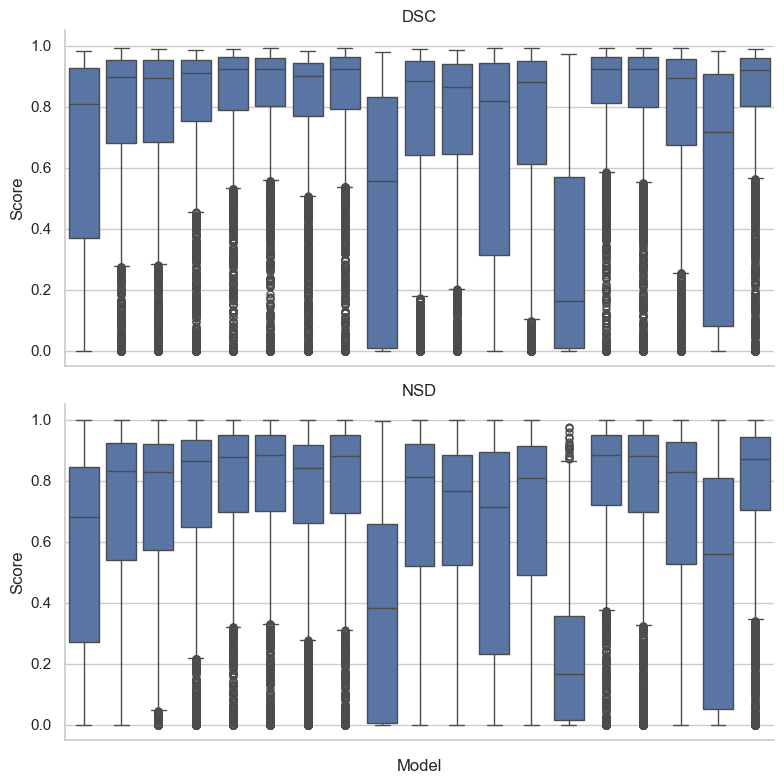

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List model directories (ignoring non-directory files)
base_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# Get a list of model directories (ignoring files like totalsegmentator_metadata.csv)
model_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(d)]


model_dirs = os.listdir(base_dir)

# Prepare an empty list to store data
data_list = []

# Loop over each model directory
for model in model_dirs:
    dsc_path = os.path.join(base_dir, model, 'dsc.csv')
    nsd_path = os.path.join(base_dir, model, 'nsd.csv')
    if os.path.exists(dsc_path) and os.path.exists(nsd_path):
        # Load DSC data and flatten the per-organ scores
        df_dsc = pd.read_csv(dsc_path)
        dsc_values = pd.to_numeric(df_dsc.drop(columns='name').values.flatten(), errors='coerce')
        dsc_values = pd.Series(dsc_values).dropna()
        temp_dsc = pd.DataFrame({
            'model': model,
            'metric': 'DSC',
            'value': dsc_values
        })

        # Load NSD data and flatten
        df_nsd = pd.read_csv(nsd_path)
        nsd_values = pd.to_numeric(df_nsd.drop(columns='name').values.flatten(), errors='coerce')
        nsd_values = pd.Series(nsd_values).dropna()
        temp_nsd = pd.DataFrame({
            'model': model,
            'metric': 'NSD',
            'value': nsd_values
        })

        data_list.extend([temp_dsc, temp_nsd])
    else:
        print(f"Warning: Missing DSC or NSD file in {model}")

# Combine all the data into one DataFrame
df_all = pd.concat(data_list, ignore_index=True)

# Set up the colors: pastel orange for DSC, pastel blue for NSD
palette = {'DSC': '#aec6cf', 'NSD': '#ffcc99'}

# Create the boxplot with models on the x-axis and metrics as the hue
plt.figure(figsize=(12, 6))
ax = sns.boxplot(x='value', y='model', hue='metric', data=df_all, palette=palette)
plt.xticks(rotation=90)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance: DSC vs NSD')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# boring plots

# Plot: we want a boxplot for each metric (DSC and NSD) in its own row.
sns.set(style="whitegrid")
g = sns.catplot(
    data=df_all,
    x='model',
    y='value',
    col='metric',
    kind='box',
    col_wrap=1,     # one plot per row
    height=4,
    aspect=2
)

# Rotate x-axis labels so they are readable
g.set_xticklabels(rotation=90)
g.set_axis_labels("Model", "Score")
g.set_titles("{col_name}")

plt.tight_layout()
plt.show()

### Heatmap

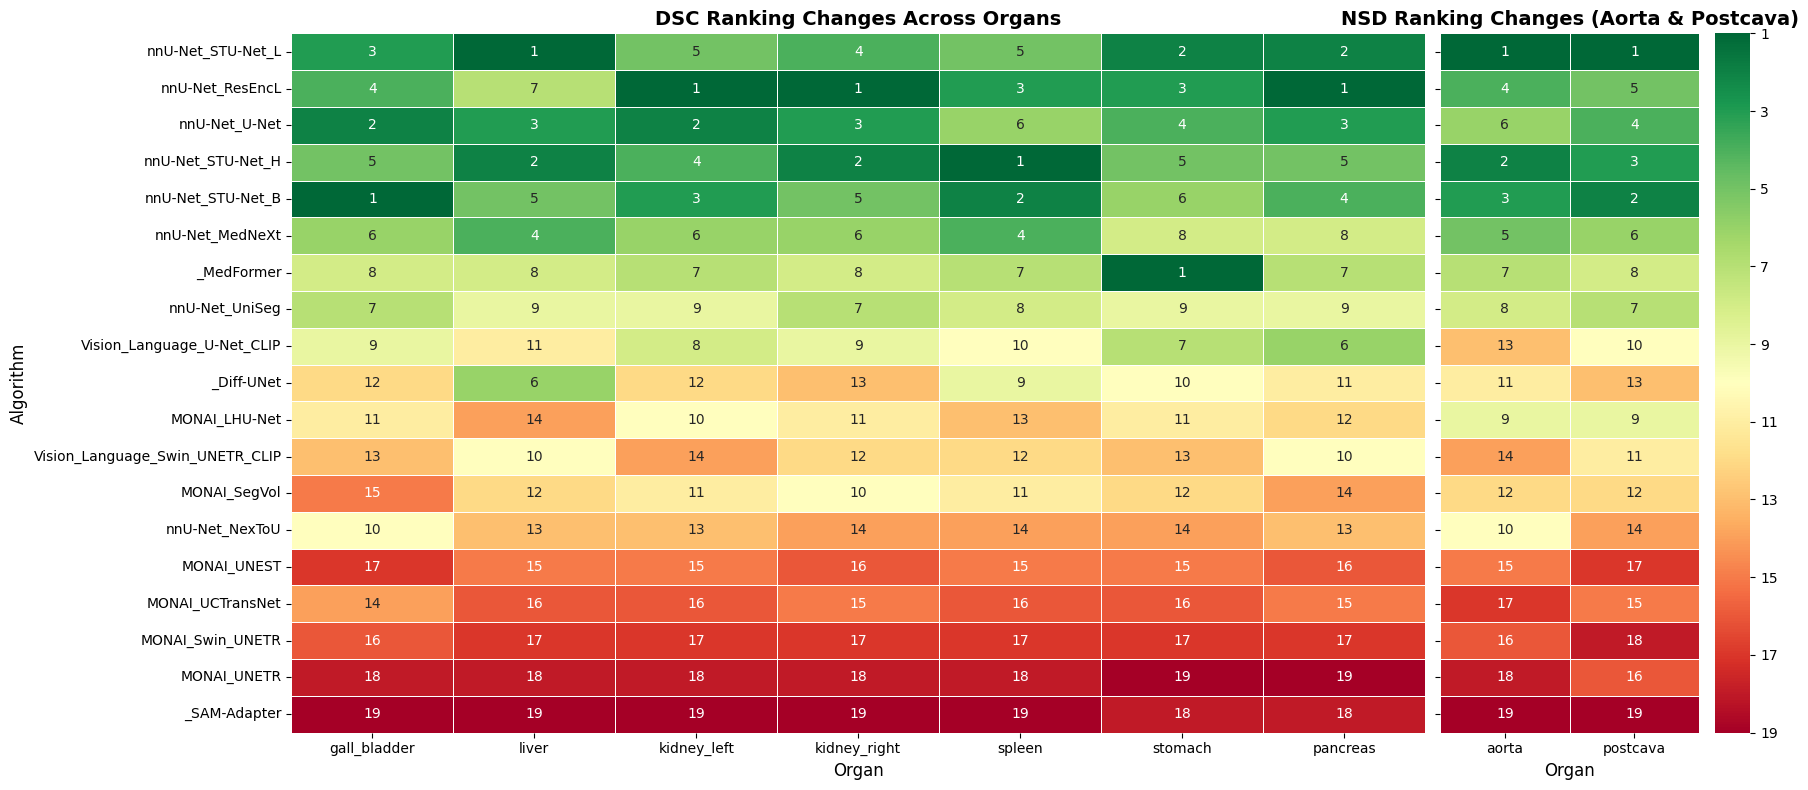

In [4]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Load Performance Data ---
base_dir = "./totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# Define organs
all_organs = ["aorta", "gall_bladder", "kidney_left", "kidney_right",
              "liver", "pancreas", "postcava", "spleen", "stomach"]

# Define which organs use DSC vs. NSD
organs_use_nsd = {"aorta", "postcava"}
organs_use_dsc = set(all_organs) - organs_use_nsd

# Load DSC and NSD data
all_model_data = []

for model in os.listdir(base_dir):
    model_path = os.path.join(base_dir, model)
    if not os.path.isdir(model_path):
        continue

    # Read DSC file if available
    dsc_file = os.path.join(model_path, "dsc.csv")
    if os.path.exists(dsc_file):
        df_dsc = pd.read_csv(dsc_file)
        df_dsc = df_dsc.melt(id_vars=['name'], var_name='organ', value_name='value')
        df_dsc["model"] = model
        df_dsc["metric"] = "DSC"
        df_dsc.dropna(inplace=True)
        all_model_data.append(df_dsc)

    # Read NSD file if available
    nsd_file = os.path.join(model_path, "nsd.csv")
    if os.path.exists(nsd_file):
        df_nsd = pd.read_csv(nsd_file)
        df_nsd = df_nsd.melt(id_vars=['name'], var_name='organ', value_name='value')
        df_nsd["model"] = model
        df_nsd["metric"] = "NSD"
        df_nsd.dropna(inplace=True)
        all_model_data.append(df_nsd)

# Merge all collected data
df_all_models = pd.concat(all_model_data, ignore_index=True)

# --- Compute Rankings for Each Organ ---
ranking_df = df_all_models.groupby(["model", "organ"])["value"].mean().unstack()

# Compute ranks (higher values = better, so we reverse rank order)
rankings = ranking_df.rank(ascending=False)

# --- Separate DSC and NSD Rankings ---
nsd_ranking_sorted = rankings.loc[:, list(organs_use_nsd)]
dsc_ranking_sorted = rankings.loc[:, list(organs_use_dsc)]

# --- Sort Algorithms by Median DSC Rank for Consistency ---
sorted_models = dsc_ranking_sorted.median(axis=1).sort_values().index

# Reorder rankings for visualization
dsc_ranking_sorted = dsc_ranking_sorted.loc[sorted_models]
nsd_ranking_sorted = nsd_ranking_sorted.loc[sorted_models]


# --- Create Shared Heatmap Plot (DSC + NSD in One Figure) with Fixed Legend ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [len(dsc_ranking_sorted.columns), len(nsd_ranking_sorted.columns)]})

# Define the **pastel green-to-red** color palette (green = best rank, red = worst)
pastel_green_red = sns.color_palette("RdYlGn_r", as_cmap=True)

# DSC Ranking Heatmap
sns.heatmap(dsc_ranking_sorted, annot=True, cmap=pastel_green_red, linewidths=0.5, cbar=False, ax=ax1)
ax1.set_title("DSC Ranking Changes Across Organs", fontsize=14, fontweight="bold")
ax1.set_xlabel("Organ", fontsize=12)
ax1.set_ylabel("Algorithm", fontsize=12)

# Compute integer tick locations for the NSD heatmap legend
min_rank, max_rank = int(nsd_ranking_sorted.values.min()), int(nsd_ranking_sorted.values.max())
tick_positions = np.arange(min_rank, max_rank + 1, 2)  # Steps of 2

# NSD Ranking Heatmap with **fixed integer legend**
sns.heatmap(nsd_ranking_sorted, annot=True, cmap=pastel_green_red, linewidths=0.5, cbar=True,
            cbar_kws={"ticks": tick_positions}, ax=ax2)
ax2.set_title("NSD Ranking Changes (Aorta & Postcava)", fontsize=14, fontweight="bold")
ax2.set_xlabel("Organ", fontsize=12)
ax2.set_ylabel("")  # Remove redundant label

# Get colorbar and **reverse it**
colorbar = ax2.collections[0].colorbar
colorbar.ax.invert_yaxis()  # Best ranks (1,2,3) at the top
colorbar.set_ticks(tick_positions)  # Ensure integer steps of 2

# Align axes
ax2.set_yticks(ax1.get_yticks())
ax2.set_yticklabels([])  # Hide y-tick labels on NSD side for clarity

# Adjust layout
plt.tight_layout()
plt.show()

# Demographics - JHH

In [ ]:
main_folder_path = "/Users/ariellubonja/prog/alans_lab/miccai_2025/Touchstone/totalsegmentator_results/final_14dec2024_results/jhh_results - table 2 in paper"

## Univariate

DPD implemented as a difference of proportions

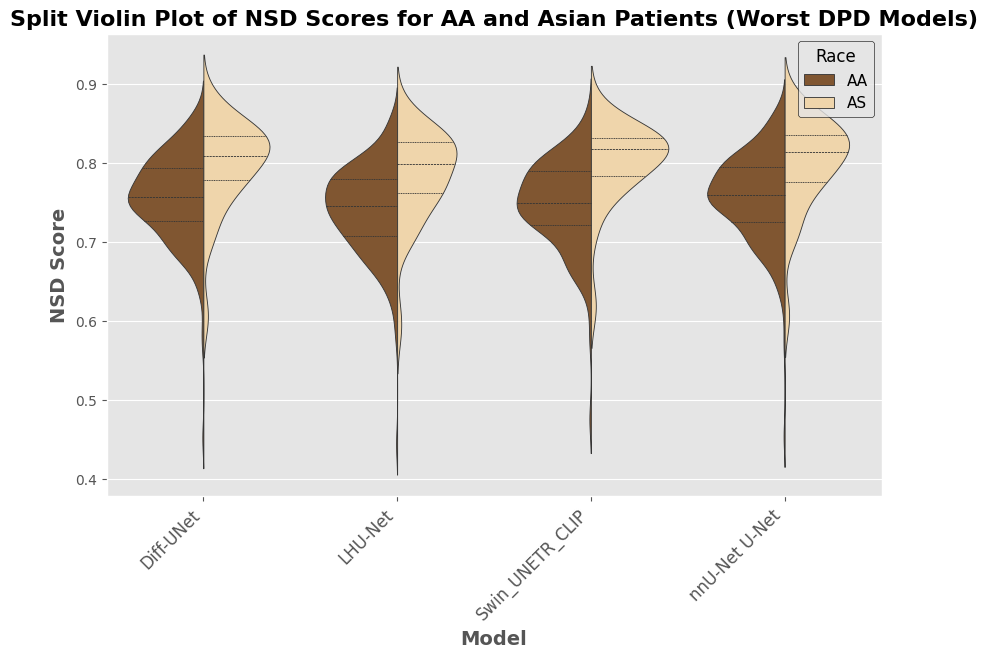

In [17]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load metadata
metadata_file_path = os.path.join(main_folder_path, "jhh_metadata - for version 20.csv")
df_metadata = pd.read_csv(metadata_file_path)

# Load NSD.csv files
model_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]
nsd_data = {}

for model in model_folders:
    nsd_file_path = os.path.join(main_folder_path, model, 'nsd.csv')
    if os.path.exists(nsd_file_path):
        df_nsd = pd.read_csv(nsd_file_path)
        df_nsd['Model'] = model  # Add model name
        nsd_data[model] = df_nsd

# Combine NSD data
df_nsd_all = pd.concat(nsd_data.values(), ignore_index=True)

# Compute mean NSD per patient across all organs
df_nsd_all['mean_nsd'] = df_nsd_all.drop(columns=['name', 'Model']).mean(axis=1)

# Merge NSD with metadata
df_metadata_subset = df_metadata[['name', 'race']]
df_nsd_full = df_nsd_all[['name', 'Model', 'mean_nsd']].merge(df_metadata_subset, on='name', how='left')

# Filter only AA and Asian patients
df_nsd_aa_asian = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

"""
# OPTION 1: Select models based on largest tail difference
def compute_tail_length(df):
    stats = df.groupby('Model')['mean_nsd'].describe()
    stats['Tail Length'] = (stats['max'] - stats['75%']) + (stats['25%'] - stats['min'])
    return stats

tail_stats = compute_tail_length(df_nsd_aa_asian)
selected_models = tail_stats.sort_values(by='Tail Length', ascending=False).head(4).index.tolist()
"""

"""
# OPTION 2: Manually select models
selected_models = ['Model_A', 'Model_B', 'Model_C', 'Model_D']  # Replace with actual model names
"""

# OPTION 3 (ACTIVE CODE): Select 4 models with the worst DPD (AS vs AA)
df_nsd_dpd = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

# Compute the probability of achieving a high NSD score (above the median)
median_nsd = df_nsd_dpd['mean_nsd'].median()

# Compute probability per model
dpd_as = df_nsd_dpd[df_nsd_dpd['race'] == 'AS'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())
dpd_aa = df_nsd_dpd[df_nsd_dpd['race'] == 'AA'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())

# Compute DPD (AS - AA)
dpd_values = dpd_as - dpd_aa

# Select the 4 models with the worst DPD (highest disparity)
selected_models = dpd_values.sort_values(ascending=False).head(4).index.tolist()

# Filter dataset for selected models
df_nsd_aa_asian_filtered = df_nsd_aa_asian[df_nsd_aa_asian['Model'].isin(selected_models)]

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='mean_nsd', hue='race', data=df_nsd_aa_asian_filtered, split=True, inner='quartile',
               palette={"AA": "#8D5524", "AS": "#FAD7A0"})  # Skin-tone-inspired colors

# Formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('NSD Score', fontsize=14, fontweight='bold')
plt.title('Split Violin Plot of NSD Scores for AA and Asian Patients (Worst DPD Models)', fontsize=16, fontweight='bold')

# Adjust legend
plt.legend(title="Race", title_fontsize=12, fontsize=11, loc='upper right', frameon=True, edgecolor='black')

# Show the plot
plt.show()


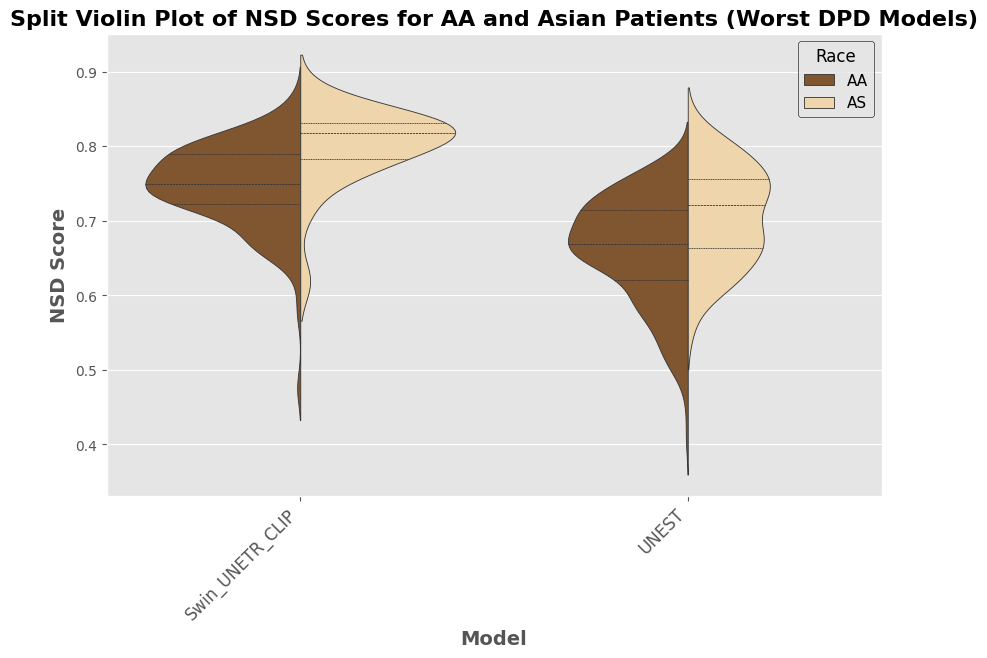

In [29]:
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load metadata
metadata_file_path = os.path.join(main_folder_path, "jhh_metadata - for version 20.csv")
df_metadata = pd.read_csv(metadata_file_path)

# Load NSD.csv files
model_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]
nsd_data = {}

for model in model_folders:
    nsd_file_path = os.path.join(main_folder_path, model, 'nsd.csv')
    if os.path.exists(nsd_file_path):
        df_nsd = pd.read_csv(nsd_file_path)
        df_nsd['Model'] = model  # Add model name
        nsd_data[model] = df_nsd

# Combine NSD data
df_nsd_all = pd.concat(nsd_data.values(), ignore_index=True)

# Compute mean NSD per patient across all organs
df_nsd_all['mean_nsd'] = df_nsd_all.drop(columns=['name', 'Model']).mean(axis=1)

# Merge NSD with metadata
df_metadata_subset = df_metadata[['name', 'race']]
df_nsd_full = df_nsd_all[['name', 'Model', 'mean_nsd']].merge(df_metadata_subset, on='name', how='left')

# Filter only AA and Asian patients
df_nsd_aa_asian = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

"""
# OPTION 1: Select models based on largest tail difference
def compute_tail_length(df):
    stats = df.groupby('Model')['mean_nsd'].describe()
    stats['Tail Length'] = (stats['max'] - stats['75%']) + (stats['25%'] - stats['min'])
    return stats

tail_stats = compute_tail_length(df_nsd_aa_asian)
selected_models = tail_stats.sort_values(by='Tail Length', ascending=False).head(4).index.tolist()
"""

"""
# OPTION 2: Manually select models
selected_models = ['Model_A', 'Model_B', 'Model_C', 'Model_D']  # Replace with actual model names
"""
selected_models = ['Swin_UNETR_CLIP', 'UNEST', 'NexToU' 'UCTransNet']
# OPTION 3 (ACTIVE CODE): Select 4 models with the worst DPD (AS vs AA)
# df_nsd_dpd = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

# # Compute the probability of achieving a high NSD score (above the median)
# median_nsd = df_nsd_dpd['mean_nsd'].median()

# # Compute probability per model
# dpd_as = df_nsd_dpd[df_nsd_dpd['race'] == 'AS'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())
# dpd_aa = df_nsd_dpd[df_nsd_dpd['race'] == 'AA'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())

# # Compute DPD (AS - AA)
# dpd_values = dpd_as - dpd_aa

# # Select the 4 models with the worst DPD (highest disparity)
# selected_models = dpd_values.sort_values(ascending=False).head(4).index.tolist()

# Filter dataset for selected models
df_nsd_aa_asian_filtered = df_nsd_aa_asian[df_nsd_aa_asian['Model'].isin(selected_models)]

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='mean_nsd', hue='race', data=df_nsd_aa_asian_filtered, split=True, inner='quartile',
               palette={"AA": "#8D5524", "AS": "#FAD7A0"})  # Skin-tone-inspired colors

# Formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('NSD Score', fontsize=14, fontweight='bold')
plt.title('Split Violin Plot of NSD Scores for AA and Asian Patients (Worst DPD Models)', fontsize=16, fontweight='bold')

# Adjust legend
plt.legend(title="Race", title_fontsize=12, fontsize=11, loc='upper right', frameon=True, edgecolor='black')

# Show the plot
plt.show()


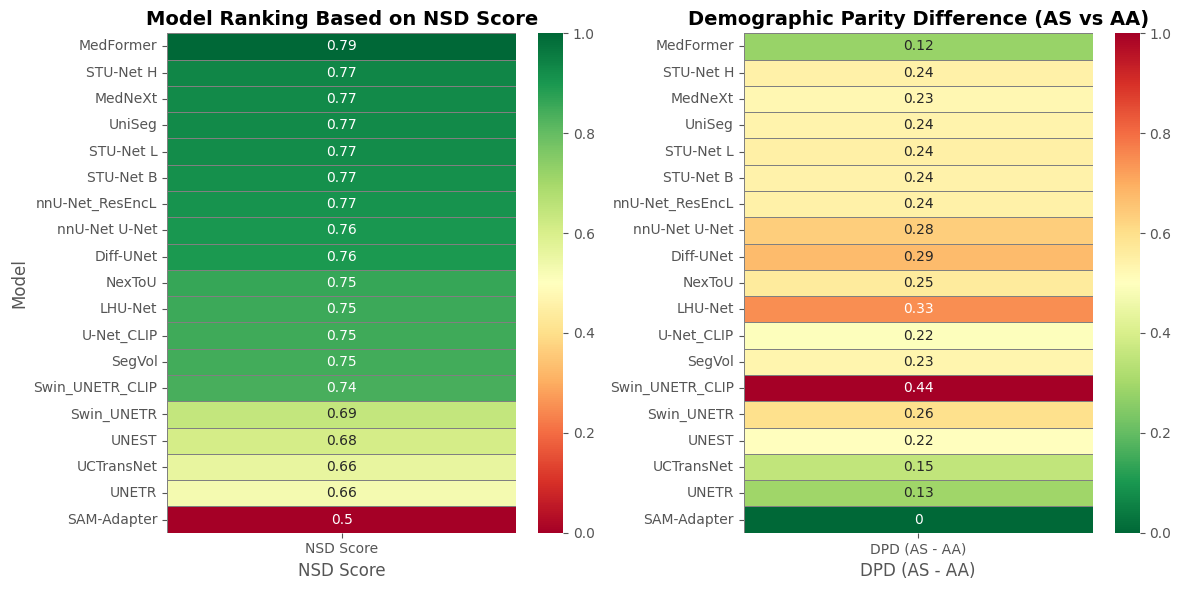

In [15]:
# Compute NSD ranking per model
model_nsd_means = df_nsd_full.groupby('Model')['mean_nsd'].mean().sort_values(ascending=False)
model_nsd_ranks = model_nsd_means.rank(ascending=False, method='dense')

# Filter only AA and Asian patients for DPD computation
df_nsd_dpd = df_nsd_full[df_nsd_full['race'].isin(['AA', 'AS'])]

# Compute the probability of achieving a high NSD score (above the median)
median_nsd = df_nsd_dpd['mean_nsd'].median()

# Compute probability per model
dpd_as = df_nsd_dpd[df_nsd_dpd['race'] == 'AS'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())
dpd_aa = df_nsd_dpd[df_nsd_dpd['race'] == 'AA'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())

# Compute DPD (AS - AA)
dpd_values = dpd_as - dpd_aa

# Combine rankings into DataFrame
ranking_data = pd.DataFrame({
    'NSD Score': model_nsd_means,
    'NSD Rank': model_nsd_ranks,
    'DPD (AS - AA)': dpd_values
}).sort_values(by='NSD Rank')

# Normalize values for heatmap consistency
ranking_data_normalized = (ranking_data - ranking_data.min()) / (ranking_data.max() - ranking_data.min())

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for NSD Score ranking
sns.heatmap(ranking_data_normalized[['NSD Score']], annot=ranking_data[['NSD Score']].round(3), cmap='RdYlGn',
            linewidths=0.5, linecolor='gray', cbar=True, ax=axes[0])
axes[0].set_title('Model Ranking Based on NSD Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('NSD Score')
axes[0].set_ylabel('Model')

# Heatmap for DPD (AS vs. AA)
sns.heatmap(ranking_data_normalized[['DPD (AS - AA)']], annot=ranking_data[['DPD (AS - AA)']].round(3),
            cmap='RdYlGn_r', linewidths=0.5, linecolor='gray', cbar=True, ax=axes[1])
axes[1].set_title('Demographic Parity Difference (AS vs AA)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('DPD (AS - AA)')
axes[1].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()


## Verification

o3-mini-high

                name ages sex race  diagnosis
18    BDMAP_V0000982   53   F   AS  no_cancer
19    BDMAP_A0000982   53   F   AS  no_cancer
150   BDMAP_V0001051   49   F   AA  no_cancer
151   BDMAP_A0001051   49   F   AA  no_cancer
168   BDMAP_A0001061   36   F   AA  no_cancer
...              ...  ...  ..  ...        ...
2910  BDMAP_A0001371   47   F   AA  no_cancer
2919  BDMAP_V0001387   51   F   AA  no_cancer
2920  BDMAP_A0001387   51   F   AA  no_cancer
2921  BDMAP_V0001390   60   M   AS  no_cancer
2922  BDMAP_A0001390   60   M   AS  no_cancer

[263 rows x 5 columns]


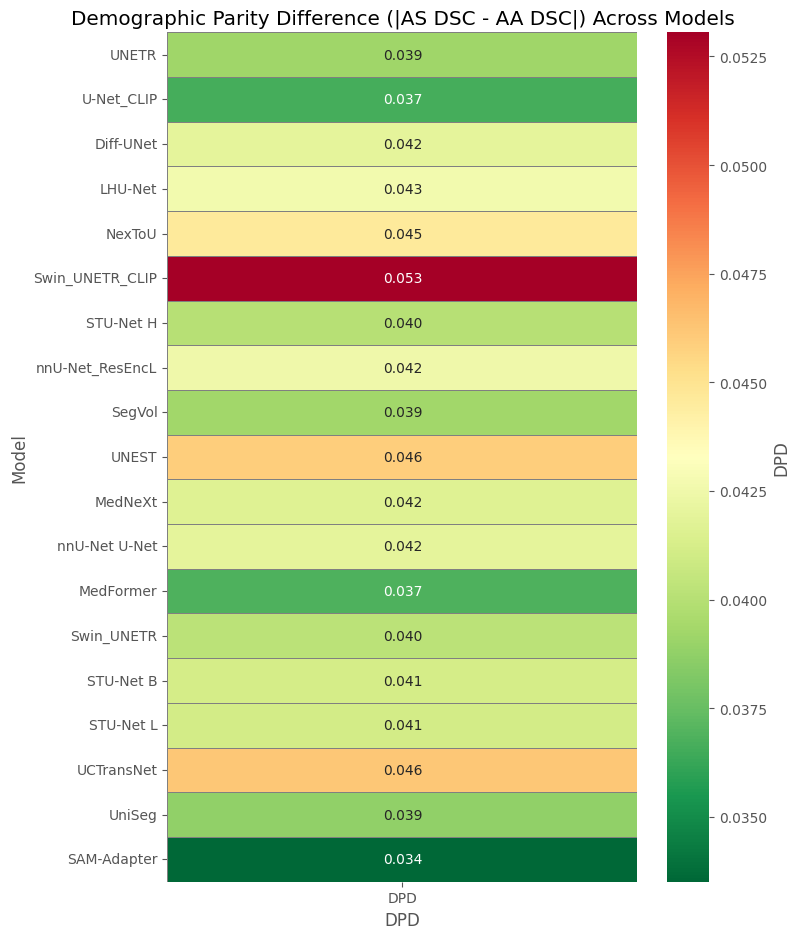

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----- CONFIGURATION -----
# List of folders (models) to process. You can also auto-detect directories that contain a dsc.csv.
model_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]


metadata = df_metadata[df_metadata['race'].isin(['AS', 'AA'])]

print(metadata)

# Dictionary to store DPD for each model
dpd_dict = {}

# ----- PROCESS EACH MODEL -----
for model in model_folders:
    nsd_file_path = os.path.join(main_folder_path, model, 'nsd.csv')
    if os.path.exists(nsd_file_path):
        nsd_df = pd.read_csv(nsd_file_path)

    dsc_df = nsd_df # Fake it

    # Merge DSC results with metadata on the 'name' column
    merged = pd.merge(dsc_df, metadata, on='name', how='inner')

    if merged.empty:
        print(f"No overlapping subjects for model {model}. Skipping.")
        continue

    # Identify DSC columns (all columns from dsc file except 'name')
    dsc_columns = list(dsc_df.columns)
    dsc_columns.remove('name')

    # Compute average DSC per subject over available organs (ignoring NaNs)
    merged['avg_dsc'] = merged[dsc_columns].mean(axis=1, skipna=True)

    # Compute mean DSC per race group
    mean_AS = merged.loc[merged['race'] == 'AS', 'avg_dsc'].mean()
    mean_AA = merged.loc[merged['race'] == 'AA', 'avg_dsc'].mean()

    # Check if both race groups exist; if not, skip this model.
    if pd.isna(mean_AS) or pd.isna(mean_AA):
        print(f"Model {model} does not have both AS and AA patients. Skipping.")
        continue

    # Compute demographic parity difference.
    # Here, we take the absolute difference so that models closer to parity (0) are better.
    dpd = abs(mean_AS - mean_AA)
    dpd_dict[model] = dpd

# Convert the dictionary into a DataFrame
dpd_df = pd.DataFrame.from_dict(dpd_dict, orient='index', columns=['DPD'])

# ----- PLOT THE HEATMAP -----
# We want a colormap where a DPD of 0 is green (best) and higher differences are red (worst).
plt.figure(figsize=(8, max(4, len(dpd_df) * 0.5)))
sns.heatmap(dpd_df, annot=True, fmt=".3f", cmap="RdYlGn_r", cbar_kws={'label': 'DPD'},
            linewidths=0.5, linecolor='gray')
plt.title('Demographic Parity Difference (|AS DSC - AA DSC|) Across Models')
plt.ylabel('Model')
plt.xlabel('DPD')
plt.tight_layout()
plt.show()


In [21]:
dpd_df

,DPD


## Intersectional

### Split Violin plot

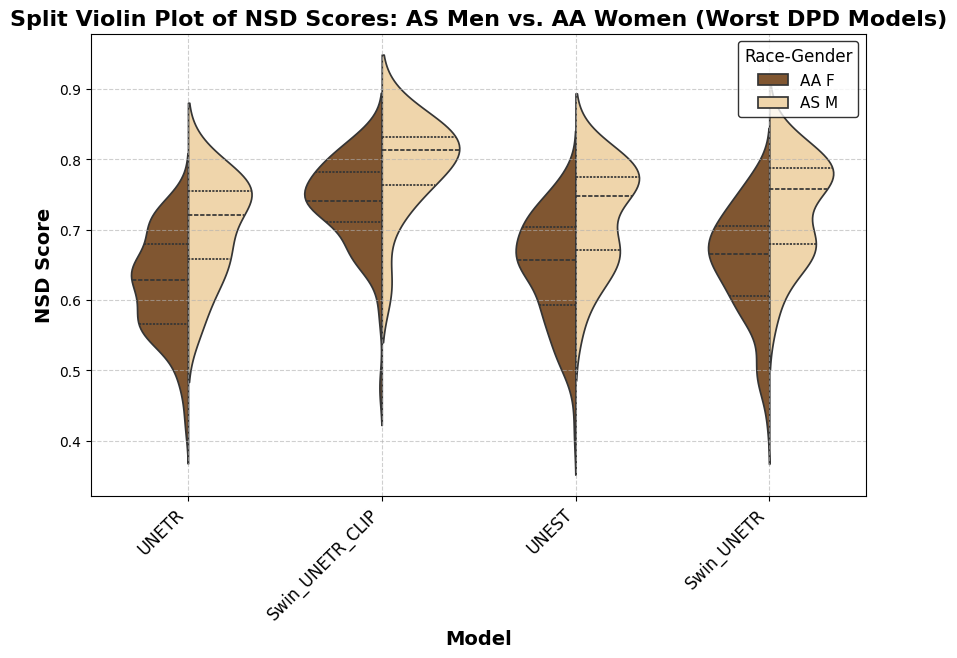

In [9]:
# Import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

main_folder_path = "/Users/ariellubonja/prog/alans_lab/miccai_2025/Touchstone/totalsegmentator_results/final_14dec2024_results/jhh_results - table 2 in paper"

# Load the metadata file
metadata_file_path = os.path.join(main_folder_path, "jhh_metadata - for version 20.csv")
df_metadata = pd.read_csv(metadata_file_path)

# List all model directories
model_folders = [f for f in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, f))]

# Initialize a dictionary to store NSD data
nsd_data = {}

# Loop through each model folder and load the NSD.csv files
for model in model_folders:
    nsd_file_path = os.path.join(main_folder_path, model, 'nsd.csv')

    if os.path.exists(nsd_file_path):
        df_nsd = pd.read_csv(nsd_file_path)
        df_nsd['Model'] = model  # Add model name
        nsd_data[model] = df_nsd

# Combine all NSD data into a single DataFrame
df_nsd_all = pd.concat(nsd_data.values(), ignore_index=True)

# Compute mean NSD across all organs for each patient (excluding 'name' and 'Model' columns)
df_nsd_all['mean_nsd'] = df_nsd_all.drop(columns=['name', 'Model']).mean(axis=1)

# Select relevant columns from metadata
df_metadata_subset = df_metadata[['name', 'race', 'sex']]

# Merge NSD scores with metadata to include race and gender information
df_nsd_full = df_nsd_all[['name', 'Model', 'mean_nsd']].merge(df_metadata_subset, on='name', how='left')

# Filter dataset for only AS Men and AA Women
df_nsd_filtered_dpd = df_nsd_full[((df_nsd_full['race'] == 'AA') & (df_nsd_full['sex'] == 'F')) |
                                  ((df_nsd_full['race'] == 'AS') & (df_nsd_full['sex'] == 'M'))]

# Compute the probability of achieving a high NSD score (above the median)
median_nsd = df_nsd_filtered_dpd['mean_nsd'].median()

# Compute the probability per model
dpd_as_men = df_nsd_filtered_dpd[df_nsd_filtered_dpd['race'] == 'AS'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())
dpd_aa_women = df_nsd_filtered_dpd[df_nsd_filtered_dpd['race'] == 'AA'].groupby('Model').apply(lambda x: (x['mean_nsd'] > median_nsd).mean())

# Compute DPD (AS Men - AA Women)
dpd_values = dpd_as_men - dpd_aa_women

# Identify the 4 worst models by DPD (highest disparity)
worst_dpd_models = dpd_values.sort_values(ascending=False).head(4).index.tolist()

# Filter dataset for only the worst models and race-gender groups (AA Women & Asian Men)
df_nsd_filtered_worst_dpd = df_nsd_full[(df_nsd_full['Model'].isin(worst_dpd_models)) &
                                       (((df_nsd_full['race'] == 'AA') & (df_nsd_full['sex'] == 'F')) |
                                       ((df_nsd_full['race'] == 'AS') & (df_nsd_full['sex'] == 'M')))]

# Fix SettingWithCopyWarning using .loc
df_nsd_filtered_worst_dpd = df_nsd_filtered_worst_dpd.copy()
df_nsd_filtered_worst_dpd['Race-Gender'] = df_nsd_filtered_worst_dpd['race'] + ' ' + df_nsd_filtered_worst_dpd['sex']

# Ensure that AS Men are only plotted for the selected worst models
df_nsd_filtered_worst_dpd = df_nsd_filtered_worst_dpd[df_nsd_filtered_worst_dpd['Model'].isin(worst_dpd_models)]

# Plot split violin plot for worst models by DPD (AS Men vs AA Women)
plt.figure(figsize=(10, 6))
sns.violinplot(x='Model', y='mean_nsd', hue='Race-Gender', data=df_nsd_filtered_worst_dpd, split=True, inner='quartile',
               palette={"AA F": "#8D5524", "AS M": "#FAD7A0"})  # Skin-tone-inspired colors

# Formatting
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Model', fontsize=14, fontweight='bold')
plt.ylabel('NSD Score', fontsize=14, fontweight='bold')
plt.title('Split Violin Plot of NSD Scores: AS Men vs. AA Women (Worst DPD Models)', fontsize=16, fontweight='bold')

# Adjust legend position and styling
plt.legend(title="Race-Gender", title_fontsize=12, fontsize=11, loc='upper right', frameon=True, edgecolor='black')

# Fine-tune grid and background
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


### DPD Rankings

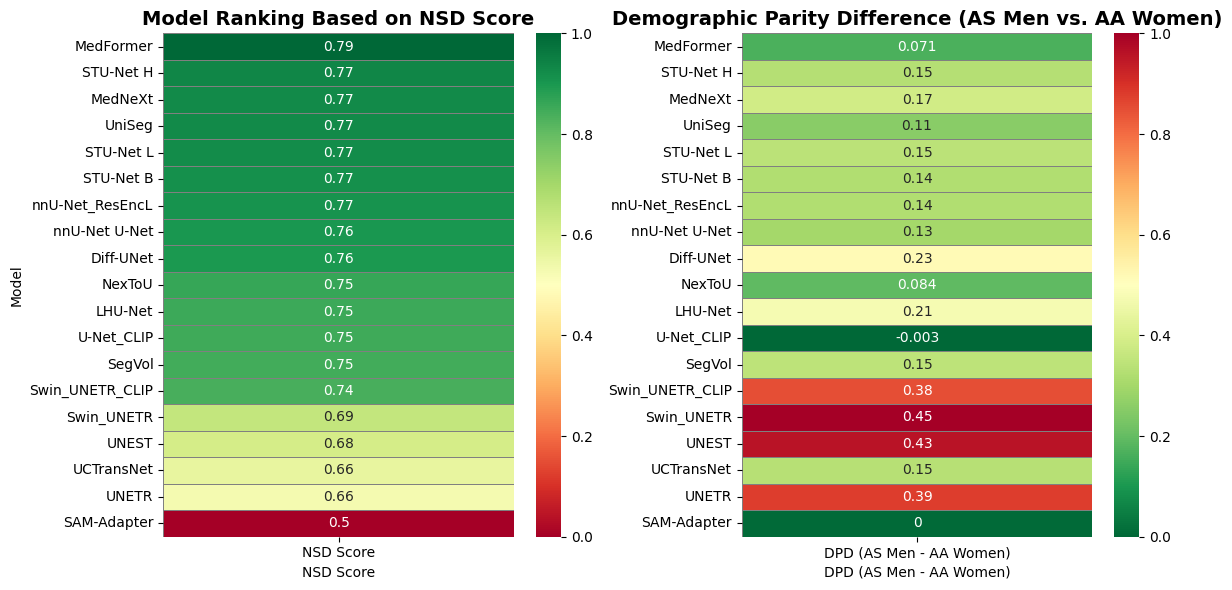

In [10]:
# Compute overall NSD mean per model for ranking
model_nsd_means = df_nsd_full.groupby('Model')['mean_nsd'].mean().sort_values(ascending=False)

# Compute ranking based on NSD scores (higher NSD = better ranking)
model_nsd_ranks = model_nsd_means.rank(ascending=False, method='dense')

# Combine NSD rank and DPD values
ranking_data = pd.DataFrame({
    'NSD Score': model_nsd_means,
    'NSD Rank': model_nsd_ranks,
    'DPD (AS Men - AA Women)': dpd_values
}).sort_values(by='NSD Rank')

# Normalize values for heatmap consistency
ranking_data_normalized = (ranking_data - ranking_data.min()) / (ranking_data.max() - ranking_data.min())

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for NSD Score (ranking models by overall NSD performance)
sns.heatmap(ranking_data_normalized[['NSD Score']], annot=ranking_data[['NSD Score']].round(3), cmap='RdYlGn',
            linewidths=0.5, linecolor='gray', cbar=True, ax=axes[0])
axes[0].set_title('Model Ranking Based on NSD Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('NSD Score')
axes[0].set_ylabel('Model')

# Heatmap for DPD (AS Men vs. AA Women)
sns.heatmap(ranking_data_normalized[['DPD (AS Men - AA Women)']], annot=ranking_data[['DPD (AS Men - AA Women)']].round(3),
            cmap='RdYlGn_r', linewidths=0.5, linecolor='gray', cbar=True, ax=axes[1])
axes[1].set_title('Demographic Parity Difference (AS Men vs. AA Women)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('DPD (AS Men - AA Women)')
axes[1].set_ylabel('')

# Adjust layout for clarity
plt.tight_layout()
plt.show()


# Demographics - TotalSegmentator

## Siemens Scanner Submodel

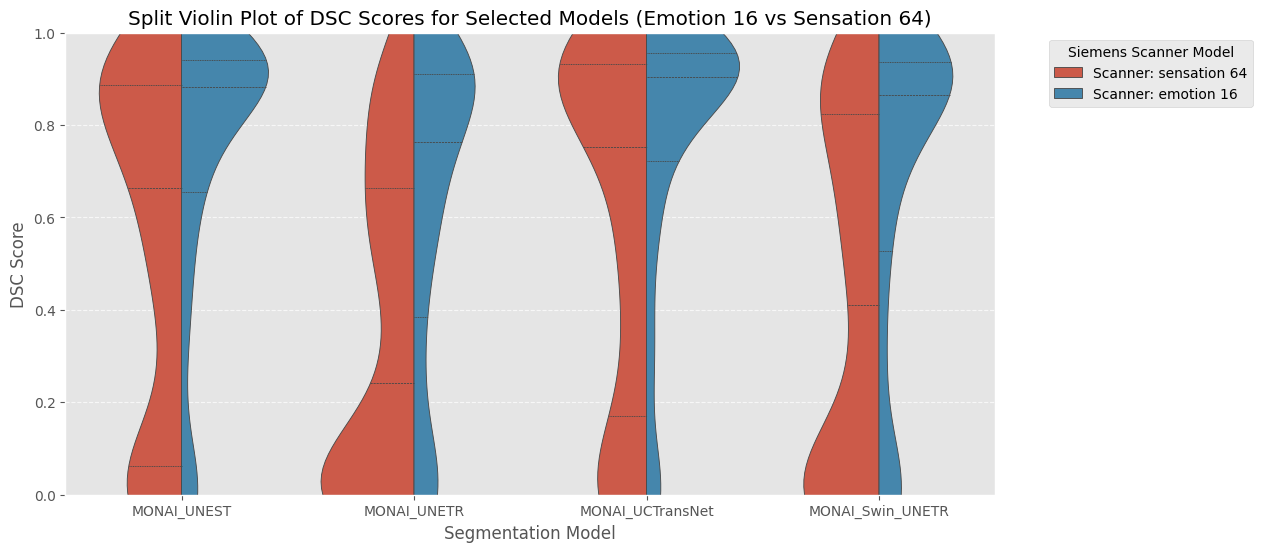

In [31]:
# Re-import necessary libraries
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Locate the main extracted directory
main_dir = "/Users/ariellubonja/prog/alans_lab/miccai_2025/Touchstone/totalsegmentator_results/final_14dec2024_results/totalsegmentator_results - table 3 in paper"

# Load metadata file
metadata_path = os.path.join(main_dir, "totalsegmentator_metadata.csv")
metadata_df = pd.read_csv(metadata_path)

# Locate all model directories
model_dirs = [d for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

# Reload performance data
performance_data = []

for model in model_dirs:
    model_path = os.path.join(main_dir, model)

    # File paths for DSC and NSD scores
    dsc_path = os.path.join(model_path, "dsc.csv")
    nsd_path = os.path.join(model_path, "nsd.csv")

    # Load files if they exist
    if os.path.exists(dsc_path) and os.path.exists(nsd_path):
        dsc_df = pd.read_csv(dsc_path)
        nsd_df = pd.read_csv(nsd_path)

        # Rename "name" to "image_id" for consistency
        dsc_df.rename(columns={"name": "image_id"}, inplace=True)
        nsd_df.rename(columns={"name": "image_id"}, inplace=True)

        # Merge DSC and NSD scores
        model_df = dsc_df.merge(nsd_df, on="image_id", suffixes=("_DSC", "_NSD"))
        model_df["model"] = model  # Add model name
        performance_data.append(model_df)

# Combine all model performance data
performance_df = pd.concat(performance_data, ignore_index=True)

# Merge performance data with metadata
performance_merged = performance_df.merge(metadata_df[["image_id", "manufacturer", "scanner_model"]], on="image_id", how="left")

# Reshape the data for computing statistics
dsc_columns = [col for col in performance_merged.columns if "_DSC" in col]
performance_long = performance_merged.melt(
    id_vars=["image_id", "manufacturer", "scanner_model", "model"],
    value_vars=dsc_columns,
    var_name="Structure",
    value_name="DSC_Score"
)

# Drop NaN values
performance_long = performance_long.dropna()

# Define the selected models
selected_models = ["MONAI_Swin_UNETR", "MONAI_UCTransNet", "MONAI_UNEST", "MONAI_UNETR"]

# Define the two Siemens scanner models to compare
scanner_models_to_compare = ["emotion 16", "sensation 64"]

# Filter the dataset for the selected models and scanners
comparison_data = performance_long[
    (performance_long["model"].isin(selected_models)) &
    (performance_long["scanner_model"].isin(scanner_models_to_compare))
].copy()

# Create a new column for violin split categories
comparison_data["Scanner Category"] = comparison_data["scanner_model"].apply(lambda x: f"Scanner: {x}")

# Plot a single violin plot with all models included, split by scanner type
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=comparison_data,
    x="model",
    y="DSC_Score",
    hue="Scanner Category",
    split=True,
    inner="quartile"
)

# Formatting
plt.title("Split Violin Plot of DSC Scores for Selected Models (Emotion 16 vs Sensation 64)")
plt.xlabel("Segmentation Model")
plt.ylabel("DSC Score")

# Restrict y-axis to valid range (0 to 1)
plt.ylim(0, 1)

# Adjust legend
plt.legend(title="Siemens Scanner Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
